# Blood Usage Prediction

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.structured import *
from fastai.column_data import *
import pandas as pd
import keras
# from ml_utils import *
from keras.models import model_from_yaml
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 20
import numpy as np
from pandas_summary import DataFrameSummary
from importlib import reload
from ml_utils.structure.viz import *
np.set_printoptions(threshold=50, edgeitems=20)

def summary_df(df):
    display(DataFrameSummary(df).summary())

PATH='./data/'

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Create Data Set

In [17]:
# !ls -alh {PATH}

In [18]:
usage_data = pd.read_csv(f'{PATH}dataprep_dept_20110101_to_20171020.csv')
hol_data = pd.read_csv(f'{PATH}hol.csv')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
usage_data = usage_data.drop(columns='Unnamed: 0')

In [20]:
def toDtStr(x):
    tmp = str(x)
    date = tmp[:8]
    return date
usage_data['trans_dt'] = pd.to_datetime(usage_data._id.apply(lambda x: toDtStr(x)))

In [21]:
usage_data.head()

,_id,DEPT_CODE,DEPT_NAME,A,B,O,AB,trans_dt
0,20110101_210201,210201,血液病科一病区,NaN,6.0,2.0,NaN,2011-01-01
1,20110101_210203,210203,血液病科二病区,NaN,2.0,NaN,NaN,2011-01-01
2,20110101_210204,210204,造血干细胞移植病房,2.0,NaN,NaN,NaN,2011-01-01
3,20110101_210205,210205,血液病科康复病区,2.0,NaN,NaN,NaN,2011-01-01
4,20110101_210302,210302,消化内科二病区,2.0,NaN,NaN,NaN,2011-01-01


In [22]:
usage_data = usage_data.rename({
    'DEPT_CODE': 'dept_code',
    'DEPT_NAME': 'dept_name'
}, axis='columns')

In [23]:
usage_data['dept_code'] = usage_data.dept_code.astype('str')

In [24]:
usage_data['code_len'] = usage_data.dept_code.apply(lambda x: len(x))
usage_data = usage_data[(usage_data.code_len <= 6) & (usage_data.code_len >= 4)]
len(usage_data)

86808

In [25]:
usage_data = usage_data[usage_data.trans_dt > '2013']
len(usage_data)

60623

In [28]:
joined_hosp = usage_data[usage_data.pdept_code != '4103']
len(joined_hosp)

56734

In [29]:
joined_hosp = joined_hosp.groupby('trans_dt').sum()

In [30]:
joined_hosp = joined_hosp.reset_index()

In [34]:
joined_hosp = addTimeFeas(joined_hosp, 'trans_dt')

In [38]:
joined_hosp = pd.merge(joined_hosp, hol_data, how='left', left_on='trans_dt', right_on='ds')

In [39]:
joined_hosp['TOTAL'] = joined_hosp.A + joined_hosp.B + joined_hosp.O + joined_hosp.AB

In [40]:
joined_hosp.head()

,trans_dt,A,B,O,AB,code_len,dow,day,month,year,week,ds,hol_dur,hol_lower,hol_upper,TOTAL
0,2013-01-02,20.0,24.5,28.0,11.0,150,2,2,1,2013,1,2013-01-02,3.0,-1.0,1.0,83.5
1,2013-01-03,22.5,22.0,23.0,11.0,168,3,3,1,2013,1,2013-01-03,3.0,-1.0,1.0,78.5
2,2013-01-04,21.5,33.5,46.0,12.0,186,4,4,1,2013,1,NaT,NaN,NaN,NaN,113.0
3,2013-01-05,28.0,25.0,43.0,21.5,166,5,5,1,2013,1,NaT,NaN,NaN,NaN,117.5
4,2013-01-06,22.0,42.0,36.5,17.5,186,6,6,1,2013,1,NaT,NaN,NaN,NaN,118.0


In [41]:
joined_hosp.to_csv('./data/joined_hosp_ner.csv', index = False)

In [26]:
usage_data['pdept_code'] = usage_data.dept_code.apply(lambda x: x[:4])
usage_data['pdept_code']= usage_data.pdept_code.astype('str')

In [252]:
len(usage_data.pdept_code.unique()), len(usage_data.dept_code.unique())

(59, 176)

In [253]:
usage_data.head()

,_id,dept_code,dept_name,A,B,O,AB,trans_dt,code_len,pdept_code
26375,20130102_111111,111111,生物治疗病区,2.0,2.0,NaN,NaN,2013-01-02,6,1111
26376,20130102_210201,210201,血液病科一病区,2.0,NaN,4.0,NaN,2013-01-02,6,2102
26377,20130102_210204,210204,造血干细胞移植病房,4.0,2.0,2.0,NaN,2013-01-02,6,2102
26378,20130102_210205,210205,血液病科康复病区,NaN,NaN,NaN,1.5,2013-01-02,6,2102
26379,20130102_210304,210304,消化内科四病区,NaN,2.0,NaN,NaN,2013-01-02,6,2103


In [254]:
pdept_data = usage_data.copy().groupby(['trans_dt', 'pdept_code']).sum()

In [260]:
len(pdept_data[pdept_data.pdept_code == '2101'])

23

In [256]:
pdept_data = pdept_data.reset_index()

In [199]:
len(pdept_data), len(pdept_data.pdept_code.unique())

(36234, 59)

In [201]:
pdept_data['dept_code'] = pdept_data.pdept_code

In [202]:
pdept_data['dept_name'] = 'tbd'

In [203]:
dept_data = usage_data.drop(columns=['_id'])[usage_data.code_len>4]

In [204]:
len(dept_data), len(dept_data.dept_code.unique())

(58299, 162)

In [200]:
pdept_data.head()

,trans_dt,pdept_code,A,B,O,AB,code_len
0,2013-01-02,1111,2.0,2.0,0.0,0.0,6
1,2013-01-02,2102,6.0,2.0,6.0,1.5,18
2,2013-01-02,2103,0.0,2.0,0.0,0.0,6
3,2013-01-02,2108,2.0,0.0,4.0,0.0,24
4,2013-01-02,2109,0.0,4.0,2.0,0.0,24


In [205]:
all_data = pd.concat([dept_data, pdept_data])

In [206]:
len(all_data), len(all_data.dept_code.unique()), len(all_data.pdept_code.unique())

(94533, 221, 59)

In [33]:
def addTimeFeas(df, dt_col):
    df = df.copy()
    df['dow'] = df[dt_col].dt.dayofweek
    df['day'] = df[dt_col].dt.day
    df['month'] = df[dt_col].dt.month
    df['year'] = df[dt_col].dt.year
    df['week'] = df[dt_col].dt.week
    return df
# all_data = addTimeFeas(all_data, 'trans_dt')

In [208]:
all_data.head()

,A,AB,B,O,code_len,dept_code,dept_name,pdept_code,trans_dt,dow,day,month,year,week
26375,2.0,NaN,2.0,NaN,6,111111,生物治疗病区,1111,2013-01-02,2,2,1,2013,1
26376,2.0,NaN,NaN,4.0,6,210201,血液病科一病区,2102,2013-01-02,2,2,1,2013,1
26377,4.0,NaN,2.0,2.0,6,210204,造血干细胞移植病房,2102,2013-01-02,2,2,1,2013,1
26378,NaN,1.5,NaN,NaN,6,210205,血液病科康复病区,2102,2013-01-02,2,2,1,2013,1
26379,NaN,NaN,2.0,NaN,6,210304,消化内科四病区,2103,2013-01-02,2,2,1,2013,1


In [35]:
hol_data.ds = pd.to_datetime(hol_data.ds)

In [36]:
hol_data['hol_lower'] = hol_data.type.apply(lambda x: -1 if x <=5 else -2)
hol_data['hol_upper'] = hol_data.type.apply(lambda x: 1 if x <=5 else 2)
hol_data = hol_data.rename({
    'type':'hol_dur'
}, axis='columns')

In [37]:
hol_data.head()

,ds,hol_dur,hol_lower,hol_upper
0,2013-01-01,3,-1,1
1,2013-01-02,3,-1,1
2,2013-01-03,3,-1,1
3,2013-02-09,7,-2,2
4,2013-02-10,7,-2,2


In [212]:
joined = pd.merge(all_data, hol_data, how='left', left_on='trans_dt', right_on='ds')
joined.head()

,A,AB,B,O,code_len,dept_code,dept_name,pdept_code,trans_dt,dow,day,month,year,week,ds,hol_dur,hol_lower,hol_upper
0,2.0,NaN,2.0,NaN,6,111111,生物治疗病区,1111,2013-01-02,2,2,1,2013,1,2013-01-02,3.0,-1.0,1.0
1,2.0,NaN,NaN,4.0,6,210201,血液病科一病区,2102,2013-01-02,2,2,1,2013,1,2013-01-02,3.0,-1.0,1.0
2,4.0,NaN,2.0,2.0,6,210204,造血干细胞移植病房,2102,2013-01-02,2,2,1,2013,1,2013-01-02,3.0,-1.0,1.0
3,NaN,1.5,NaN,NaN,6,210205,血液病科康复病区,2102,2013-01-02,2,2,1,2013,1,2013-01-02,3.0,-1.0,1.0
4,NaN,NaN,2.0,NaN,6,210304,消化内科四病区,2103,2013-01-02,2,2,1,2013,1,2013-01-02,3.0,-1.0,1.0


In [215]:
bld_types = ['A', 'AB', 'B', 'O']
for t in bld_types:
    joined[t] = joined[t].fillna(0)

In [216]:
joined['TOTAL'] = joined.A + joined.B + joined.AB + joined.O

In [217]:
joined.head()

,A,AB,B,O,code_len,dept_code,dept_name,pdept_code,trans_dt,dow,day,month,year,week,ds,hol_dur,hol_lower,hol_upper,TOTAL
0,2.0,0.0,2.0,0.0,6,111111,生物治疗病区,1111,2013-01-02,2,2,1,2013,1,2013-01-02,3.0,-1.0,1.0,4.0
1,2.0,0.0,0.0,4.0,6,210201,血液病科一病区,2102,2013-01-02,2,2,1,2013,1,2013-01-02,3.0,-1.0,1.0,6.0
2,4.0,0.0,2.0,2.0,6,210204,造血干细胞移植病房,2102,2013-01-02,2,2,1,2013,1,2013-01-02,3.0,-1.0,1.0,8.0
3,0.0,1.5,0.0,0.0,6,210205,血液病科康复病区,2102,2013-01-02,2,2,1,2013,1,2013-01-02,3.0,-1.0,1.0,1.5
4,0.0,0.0,2.0,0.0,6,210304,消化内科四病区,2103,2013-01-02,2,2,1,2013,1,2013-01-02,3.0,-1.0,1.0,2.0


In [224]:
joined['pdept_code'] = joined.pdept_code.astype('str')

In [227]:
joined['dept_code'] = joined.dept_code.astype('str')

In [228]:
joined.to_csv(f'{PATH}joined.csv', index=False)

In [316]:
!ls data

1111.jpg                               2218.jpg
2102.jpg                               4103.jpg
2103.jpg                               DICT_DEPT.txt
2104.jpg                               dataprep_dept_20110101_to_20171020.csv
2106.jpg                               dept_stats.csv
2108.jpg                               dept_stats_viz.csv
2109.jpg                               emergency.jpg
2111.jpg                               emergency_data.csv
2119.jpg                               hol.csv
2122.jpg                               hospital_all.jpg
2201.jpg                               hospital_all_noer.jpg
2202.jpg                               hospital_noer.jpg
2204.jpg                               joined.csv
2208.jpg                               joined_hosp.csv
2209.jpg                               joined_hosp_ner.csv
2210.jpg                               joined_hosp_pp.csv
2211.jpg                               models
2212.jpg                               tmp


In [317]:
hosp_df = pd.read_csv(f'{PATH}joined_hosp.csv')
hosp_df.head()

,trans_dt,A,B,O,AB,code_len,dow,day,month,year,week,ds,hol_dur,hol_lower,hol_upper,TOTAL
0,2013-01-02,24.0,24.5,30.0,13.0,154,2,2,1,2013,1,2013-01-02,3.0,-1.0,1.0,91.5
1,2013-01-03,22.5,24.0,25.0,17.0,178,3,3,1,2013,1,2013-01-03,3.0,-1.0,1.0,88.5
2,2013-01-04,21.5,33.5,54.0,12.0,190,4,4,1,2013,1,NaN,NaN,NaN,NaN,121.0
3,2013-01-05,28.0,29.0,49.0,21.5,170,5,5,1,2013,1,NaN,NaN,NaN,NaN,127.5
4,2013-01-06,30.0,48.0,39.5,18.5,196,6,6,1,2013,1,NaN,NaN,NaN,NaN,136.0


In [318]:
dept_df = pd.read_csv(f'{PATH}joined.csv')
dept_df.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,A,AB,B,O,dept_code,dept_name,pdept_code,trans_dt,dow,day,month,year,week,hol_dur,hol_lower,hol_upper,TOTAL
0,2.0,0.0,2.0,0.0,111111,生物治疗病区,1111,2013-01-02,2,2,1,2013,1,3.0,-1.0,1.0,4.0
1,2.0,0.0,0.0,4.0,210201,血液病科一病区,2102,2013-01-02,2,2,1,2013,1,3.0,-1.0,1.0,6.0
2,4.0,0.0,2.0,2.0,210204,造血干细胞移植病房,2102,2013-01-02,2,2,1,2013,1,3.0,-1.0,1.0,8.0
3,0.0,1.5,0.0,0.0,210205,血液病科康复病区,2102,2013-01-02,2,2,1,2013,1,3.0,-1.0,1.0,1.5
4,0.0,0.0,2.0,0.0,210304,消化内科四病区,2103,2013-01-02,2,2,1,2013,1,3.0,-1.0,1.0,2.0


In [319]:
hosp_df = hosp_df.drop(columns='code_len')
hosp_df['dept_code'] = '0'
hosp_df['pdept_code'] = '0'
hosp_df['dept_name'] = '全院'
hosp_df.head()

,trans_dt,A,B,O,AB,dow,day,month,year,week,ds,hol_dur,hol_lower,hol_upper,TOTAL,dept_code,pdept_code,dept_name
0,2013-01-02,24.0,24.5,30.0,13.0,2,2,1,2013,1,2013-01-02,3.0,-1.0,1.0,91.5,0,0,全院
1,2013-01-03,22.5,24.0,25.0,17.0,3,3,1,2013,1,2013-01-03,3.0,-1.0,1.0,88.5,0,0,全院
2,2013-01-04,21.5,33.5,54.0,12.0,4,4,1,2013,1,NaN,NaN,NaN,NaN,121.0,0,0,全院
3,2013-01-05,28.0,29.0,49.0,21.5,5,5,1,2013,1,NaN,NaN,NaN,NaN,127.5,0,0,全院
4,2013-01-06,30.0,48.0,39.5,18.5,6,6,1,2013,1,NaN,NaN,NaN,NaN,136.0,0,0,全院


In [321]:
hosp_df.columns, dept_df.columns

(Index(['trans_dt', 'A', 'B', 'O', 'AB', 'dow', 'day', 'month', 'year', 'week',
        'ds', 'hol_dur', 'hol_lower', 'hol_upper', 'TOTAL', 'dept_code',
        'pdept_code', 'dept_name'],
       dtype='object'),
 Index(['A', 'AB', 'B', 'O', 'dept_code', 'dept_name', 'pdept_code', 'trans_dt',
        'dow', 'day', 'month', 'year', 'week', 'hol_dur', 'hol_lower',
        'hol_upper', 'TOTAL'],
       dtype='object'))

In [323]:
dept_df['TOTAL'] = dept_df.A + dept_df.B + dept_df.AB + dept_df.O

In [325]:
dept_df['dept_code'] = dept_df.dept_code.astype('str')
dept_df['pdept_code'] = dept_df.pdept_code.astype('str')

In [330]:
dept_df.loc[dept_df.dept_code == dept_df.pdept_code, 'pdept_code'] = '0'

In [334]:
dept_df.columns, hosp_df.columns

(Index(['A', 'AB', 'B', 'O', 'dept_code', 'dept_name', 'pdept_code', 'trans_dt',
        'dow', 'day', 'month', 'year', 'week', 'hol_dur', 'hol_lower',
        'hol_upper', 'TOTAL'],
       dtype='object'),
 Index(['trans_dt', 'A', 'B', 'O', 'AB', 'dow', 'day', 'month', 'year', 'week',
        'ds', 'hol_dur', 'hol_lower', 'hol_upper', 'TOTAL', 'dept_code',
        'pdept_code', 'dept_name'],
       dtype='object'))

In [336]:
hosp_df.drop(columns = 'ds', inplace=True)

In [337]:
len(hosp_df.columns), len(dept_df.columns)

(17, 17)

In [340]:
joined = pd.concat([dept_df, hosp_df])
len(joined), len(dept_df), len(hosp_df)

(96286, 94533, 1753)

In [342]:
len(joined.columns)

17

In [344]:
joined.to_csv(f'{PATH}joined_hosp_dept.csv', index=False)

In [347]:
j = pd.read_csv(f'{PATH}joined_hosp_dept.csv', dtype={'dept_code': 'str', 'pdept_code': 'str'})

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [348]:
summary_df(j)

,A,AB,B,O,TOTAL,day,dept_code,dept_name,dow,hol_dur,hol_lower,hol_upper,month,pdept_code,trans_dt,week,year
count,96286,96286,96286,96286,96286,96286,NaN,NaN,96286,5637,5637,5637,96286,96286,NaN,96286,96286
mean,2.26103,0.852086,2.67398,2.54748,8.33458,15.8205,NaN,NaN,2.87295,4.82367,-1.45592,1.45592,6.4026,1366.5,NaN,26.0786,2014.96
std,6.57712,2.83934,7.63224,7.33699,22.4575,8.74535,NaN,NaN,1.91998,1.99239,0.498097,0.498097,3.37088,1156.16,NaN,14.7343,1.37539
min,0,0,0,0,0,1,NaN,NaN,0,3,-2,1,1,0,NaN,1,2013
25%,0,0,0,0,2,8,NaN,NaN,1,3,-2,1,4,0,NaN,13,2014
50%,0,0,0,0,3,16,NaN,NaN,3,3,-1,1,6,2105,NaN,26,2015
75%,2,0,2,2,6,23,NaN,NaN,4,7,-1,2,9,2208,NaN,38,2016
max,103,60,114,113,261.5,31,NaN,NaN,6,7,-1,2,12,6702,NaN,53,2017
counts,96286,96286,96286,96286,96286,96286,96286,96286,96286,5637,5637,5637,96286,96286,96286,96286,96286
uniques,184,91,200,202,500,31,271,164,7,2,2,2,12,59,1753,53,5


## EDA

In [3]:
joined = pd.read_csv(f'{PATH}joined.csv')
joined['dept_code'] = joined.dept_code.astype('str')
joined['pdept_code'] = joined.pdept_code.astype('str')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Emergency

In [13]:
dept_code = '4103'
dept_df = joined[joined.dept_code == dept_code]
dept_df.to_csv(f'{PATH}emergency_data.csv', index=False)

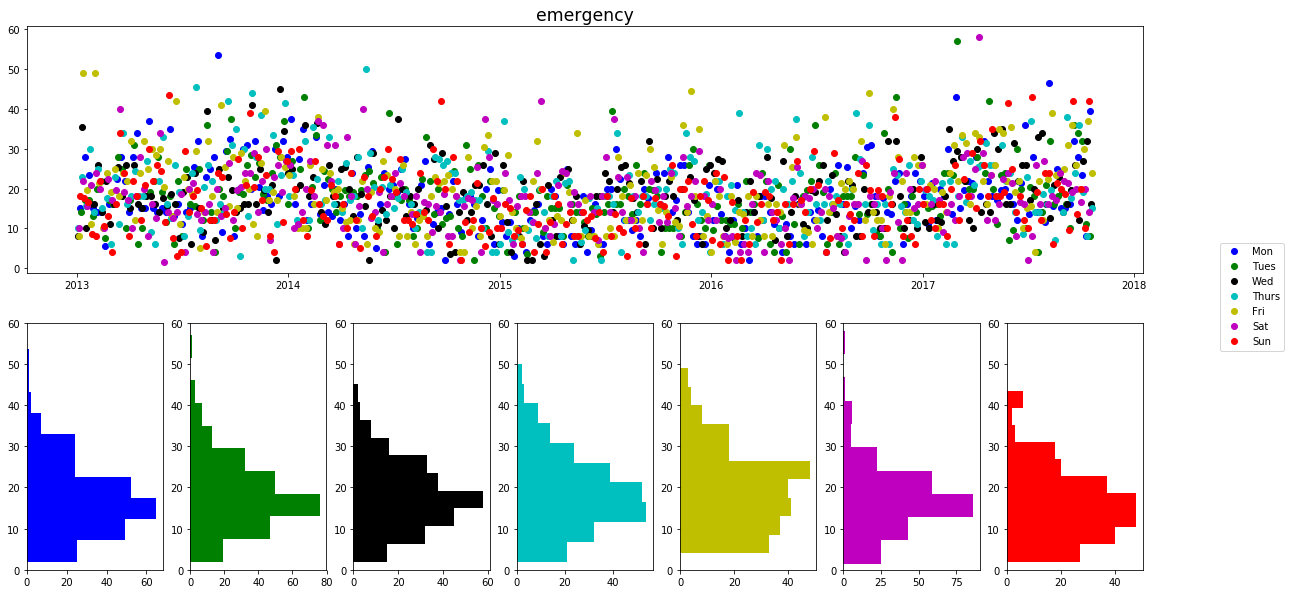

In [14]:
plot_seasonality(dept_df, ds_col='trans_dt', y_col='TOTAL', title='emergency', save=True, path=PATH)

### Non - Emergency

In [47]:
hosp_df = pd.read_csv(f'{PATH}joined_hosp_ner.csv')
hosp_df.head()

,trans_dt,A,B,O,AB,code_len,dow,day,month,year,week,ds,hol_dur,hol_lower,hol_upper,TOTAL
0,2013-01-02,20.0,24.5,28.0,11.0,150,2,2,1,2013,1,2013-01-02,3.0,-1.0,1.0,83.5
1,2013-01-03,22.5,22.0,23.0,11.0,168,3,3,1,2013,1,2013-01-03,3.0,-1.0,1.0,78.5
2,2013-01-04,21.5,33.5,46.0,12.0,186,4,4,1,2013,1,NaN,NaN,NaN,NaN,113.0
3,2013-01-05,28.0,25.0,43.0,21.5,166,5,5,1,2013,1,NaN,NaN,NaN,NaN,117.5
4,2013-01-06,22.0,42.0,36.5,17.5,186,6,6,1,2013,1,NaN,NaN,NaN,NaN,118.0


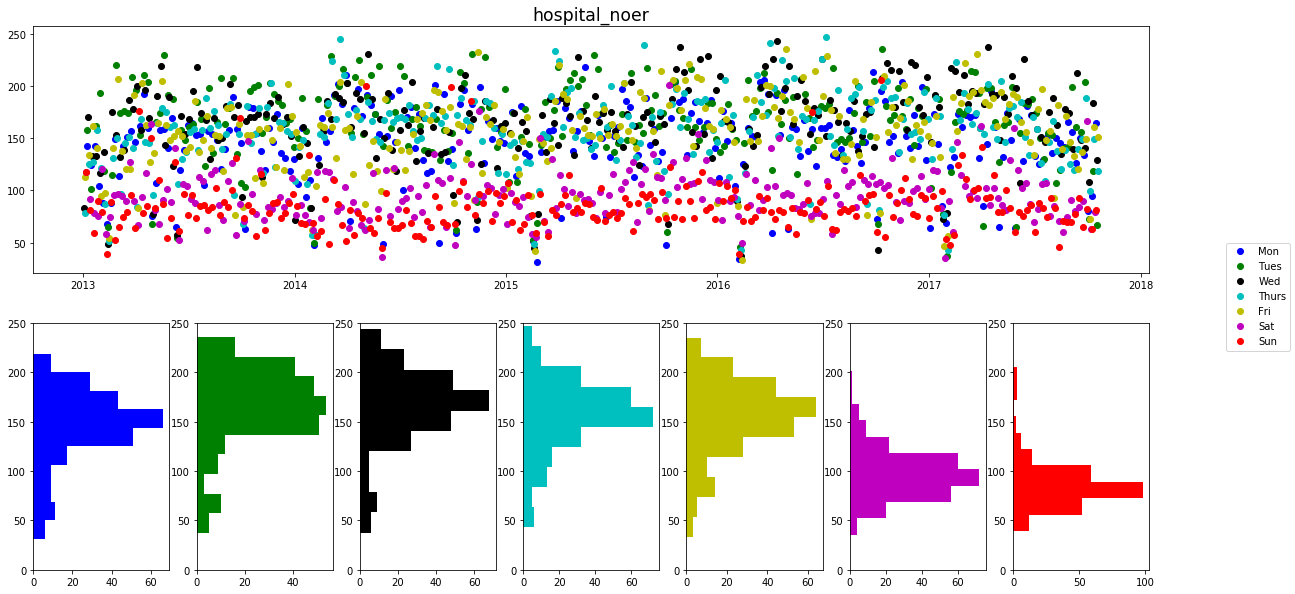

In [48]:
plot_seasonality(hosp_df, ds_col='trans_dt', y_col='TOTAL', title='hospital_noer', save=True, path=PATH)

### Dept statistics

In [221]:
len(joined)

94533

In [229]:
summary_df(joined)

,A,AB,B,O,dept_code,dept_name,pdept_code,trans_dt,dow,day,month,year,week,hol_dur,hol_lower,hol_upper,TOTAL
count,94533,94533,94533,94533,NaN,NaN,NaN,NaN,94533,94533,94533,94533,94533,5495,5495,5495,94533
mean,1.51919,0.570483,1.79709,1.71108,NaN,NaN,NaN,NaN,2.8706,15.8232,6.40392,2014.96,26.0841,4.81911,-1.45478,1.45478,5.59785
std,2.93306,1.55218,3.25311,3.1361,NaN,NaN,NaN,NaN,1.91841,8.74466,3.37081,1.37525,14.7342,1.99198,0.497996,0.497996,7.74548
min,0,0,0,0,NaN,NaN,NaN,NaN,0,1,1,2013,1,3,-2,1,0
25%,0,0,0,0,NaN,NaN,NaN,NaN,1,8,4,2014,13,3,-2,1,2
50%,0,0,0,0,NaN,NaN,NaN,NaN,3,16,6,2015,26,3,-1,1,3
75%,2,0,2,2,NaN,NaN,NaN,NaN,4,23,9,2016,38,7,-1,2,6
max,51,26.5,66,51,NaN,NaN,NaN,NaN,6,31,12,2017,53,7,-1,2,108
counts,94533,94533,94533,94533,94533,94533,94533,94533,94533,94533,94533,94533,94533,5495,5495,5495,94533
uniques,88,46,93,90,221,163,59,1753,7,31,12,5,53,2,2,2,198


In [294]:
np.max(joined.trans_dt.values)

'2017-10-20'

In [358]:
def addDeptStat(df):
    cols = ['A', 'B', 'O', 'AB', 'TOTAL']
    total_dt = 120
    dept = {
        'dept_code': [df.dept_code.unique()[0]],
        'dept_name': [df.dept_name.unique()[0]],
        'pdept_code': [df.pdept_code.unique()[0]],
        'dept_level': [1 if len(df.dept_code.unique()[0]) == 4 else 2]
    }
    for col in cols:
        sub_df = df[~df[col].isna()]
        dept[f'{col}_count'] = [len(sub_df)]
        dept[f'{col}_day_amount_mean'] = [np.sum(sub_df[col].values) / total_dt]
        dept[f'{col}_amount'] = [np.sum(sub_df[col].values)]
    dept_df = pd.DataFrame.from_dict(dept)
    dept_df = dept_df.set_index('dept_code')
    return dept_df

In [359]:
st = joined.groupby('dept_code').apply(addDeptStat)

In [373]:
st.head()

,AB_amount,AB_count,AB_day_amount_mean,A_amount,A_count,A_day_amount_mean,B_amount,B_count,B_day_amount_mean,O_amount,O_count,O_day_amount_mean,TOTAL_amount,TOTAL_count,TOTAL_day_amount_mean,dept_level,dept_name,pdept_code
dept_code,,,,,,,,,,,,,,,,,,
1111,263.0,1044,2.191667,701.5,1044,5.845833,1219.0,1044,10.158333,952.5,1044,7.9375,3136.0,1044,26.133333,1,tbd,1111
111111,263.0,1044,2.191667,701.5,1044,5.845833,1219.0,1044,10.158333,952.5,1044,7.9375,3136.0,1044,26.133333,2,生物治疗病区,1111
2101,0.0,23,0.000000,8.0,23,0.066667,29.0,23,0.241667,7.5,23,0.0625,44.5,23,0.370833,1,tbd,2101
210101,0.0,13,0.000000,8.0,13,0.066667,14.0,13,0.116667,1.5,13,0.0125,23.5,13,0.195833,2,内分泌科一病区,2101
210102,0.0,10,0.000000,0.0,10,0.000000,15.0,10,0.125000,6.0,10,0.0500,21.0,10,0.175000,2,内分泌科二病区,2101


In [372]:
st.index = st.index.droplevel()

In [376]:
st = st.reset_index()

In [377]:
st.to_csv('./data/dept_stats.csv', index=False)

### Hospital Statics

In [45]:
hosp_df = pd.read_csv(f'{PATH}joined_hosp.csv')
hosp_df.head()

,trans_dt,A,B,O,AB,code_len,dow,day,month,year,week,ds,hol_dur,hol_lower,hol_upper,TOTAL
0,2013-01-02,24.0,24.5,30.0,13.0,154,2,2,1,2013,1,2013-01-02,3.0,-1.0,1.0,91.5
1,2013-01-03,22.5,24.0,25.0,17.0,178,3,3,1,2013,1,2013-01-03,3.0,-1.0,1.0,88.5
2,2013-01-04,21.5,33.5,54.0,12.0,190,4,4,1,2013,1,NaN,NaN,NaN,NaN,121.0
3,2013-01-05,28.0,29.0,49.0,21.5,170,5,5,1,2013,1,NaN,NaN,NaN,NaN,127.5
4,2013-01-06,30.0,48.0,39.5,18.5,196,6,6,1,2013,1,NaN,NaN,NaN,NaN,136.0


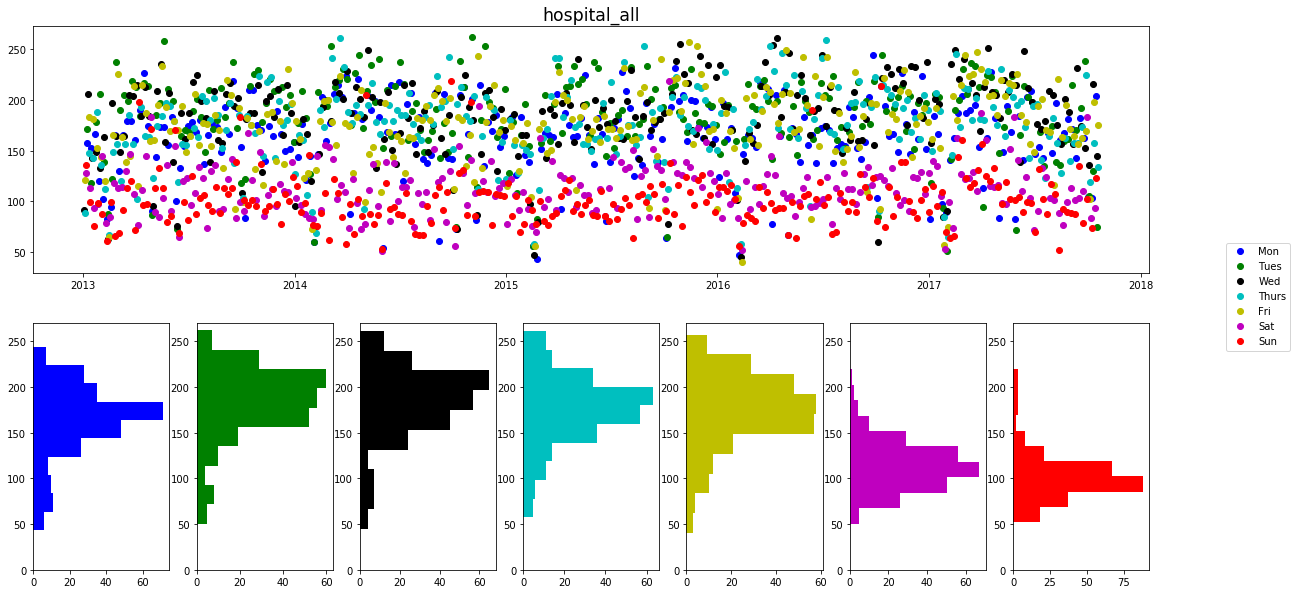

In [46]:
plot_seasonality(hosp_df, ds_col='trans_dt', y_col='TOTAL', title='hospital_all', save=True, path=PATH)

### Tipical Depts

In [5]:
dept_data = pd.read_csv(f'{PATH}dept_stats.csv')

In [6]:
l1_dept_data = dept_data[dept_data.dept_level == 1].sort_values('TOTAL_amount',  ascending=False)

In [7]:
l1_dept_data = l1_dept_data.reset_index()

In [8]:
top_depts = l1_dept_data[:20].dept_code.values.tolist()
top_depts

['2201',
 '4103',
 '2102',
 '2209',
 '2212',
 '2210',
 '2218',
 '2208',
 '2122',
 '2103',
 '2119',
 '2211',
 '2108',
 '2109',
 '2106',
 '2111',
 '2202',
 '1111',
 '2104',
 '2204']

In [4]:
def plot_seasonality(df, ds_col='ds', y_col='y', figsize=(20, 10), title='', save=False, path='./'):
  # reformat data
  data = df[[ds_col, y_col]].rename({
    ds_col: 'ds',
    y_col: 'y'
  }, axis='columns')
  
  # force ds to be datetime
  sm_df= DataFrameSummary(data).summary()
  if sm_df.loc['types'].ds != 'date':
    data['ds'] = pd.to_datetime(data.ds)

  #add DoW info
  data['dow'] = data.ds.dt.dayofweek
  dow_label = {
    '0': 'Mon',
    '1': 'Tues',
    '2': 'Wed',
    '3': 'Thurs',
    '4': 'Fri',
    '5': 'Sat',
    '6': 'Sun'
  }
  
  colors = {
    '0': 'b',
    '1': 'g',
    '2': 'k',
    '3': 'c',
    '4': 'y',
    '5': 'm',
    '6': 'r'  
  }
    
  data['dow_label'] = data.dow.apply(lambda x : dow_label[str(x)])
  
  y_max = np.ceil(np.max(data.y.values) / 10) * 10
  #plot
  plt.figure(figsize=figsize)
  plt.subplot2grid((2,7), (0,0), colspan=7)
  plt.title(title, fontsize='xx-large')
  subplots = []
  for i in range(7):
    data_sub = data[data.dow == i]
    subplots.append(plt.plot(data_sub.ds, data_sub.y, 'o' + colors[str(i)])[0])
  plt.figlegend(tuple(subplots), tuple(dow_label.values()), 'center right')

  for i in range(7):
    plt.subplot2grid((2,7), (1, i))
    data_sub = data[data.dow == i]
    plt.ylim(0, y_max)
    plt.hist(data_sub.y, orientation='horizontal', color=colors[str(i)])
  if(save):
    plt.savefig(f'{path}{title}.jpg') 

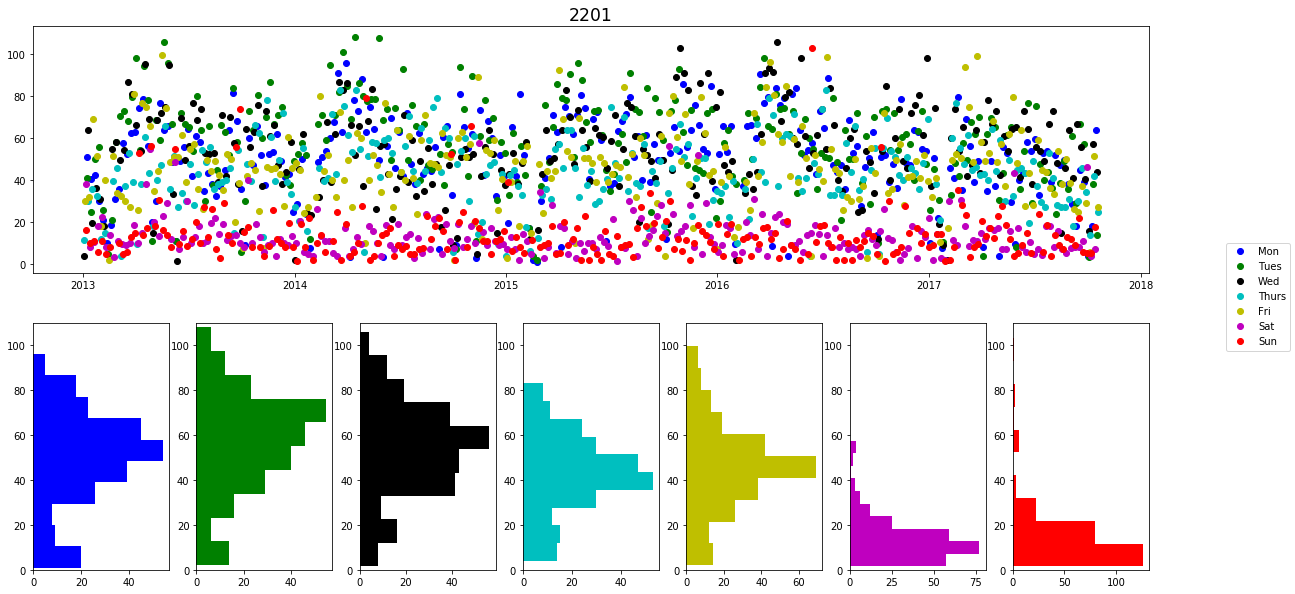

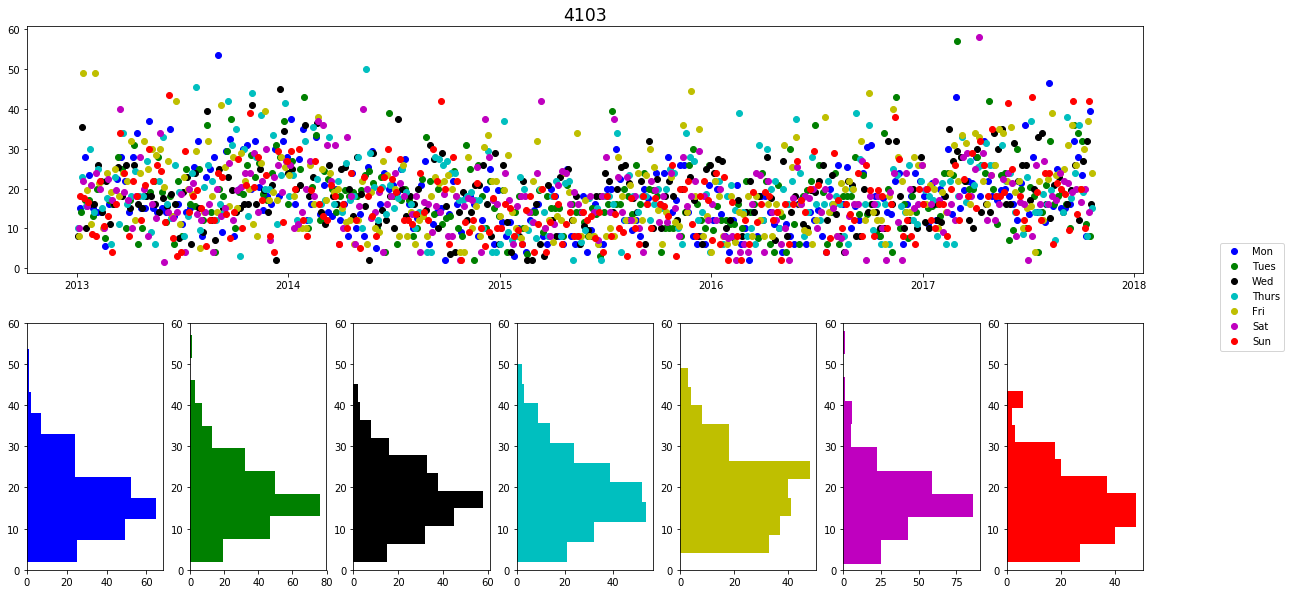

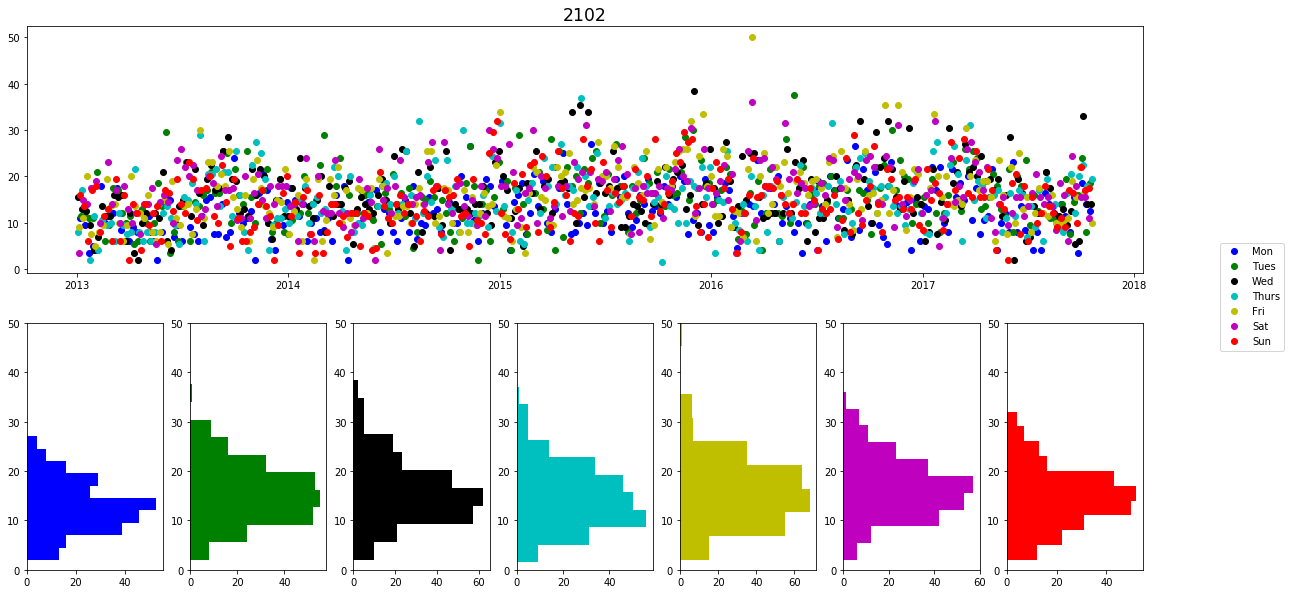

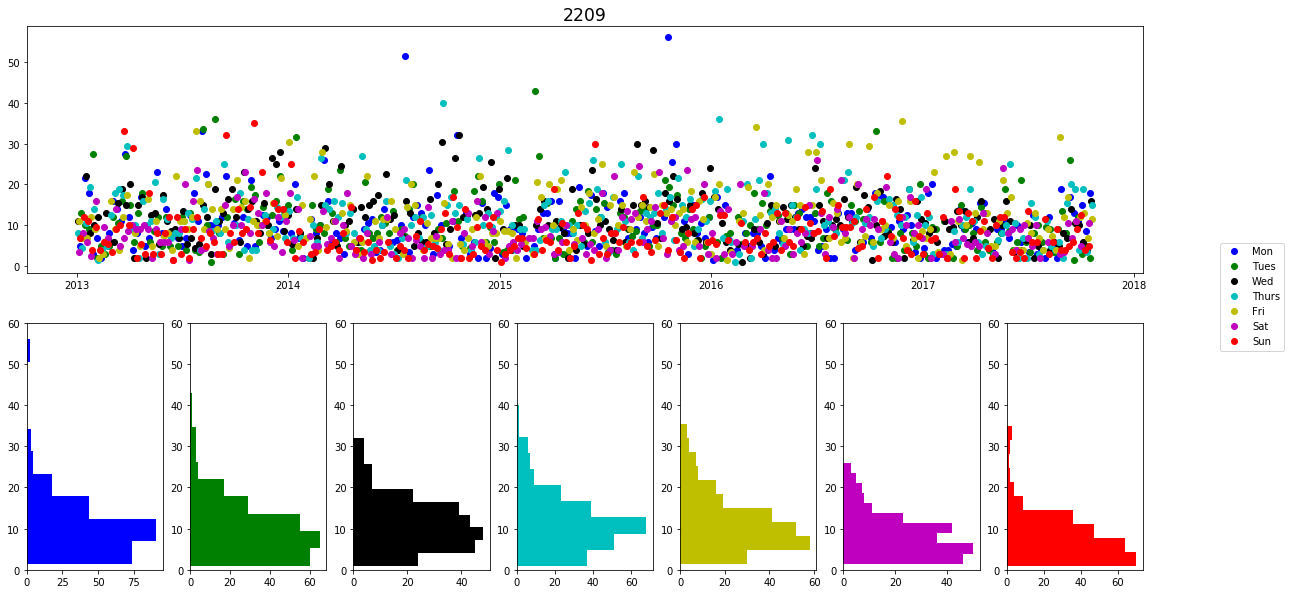

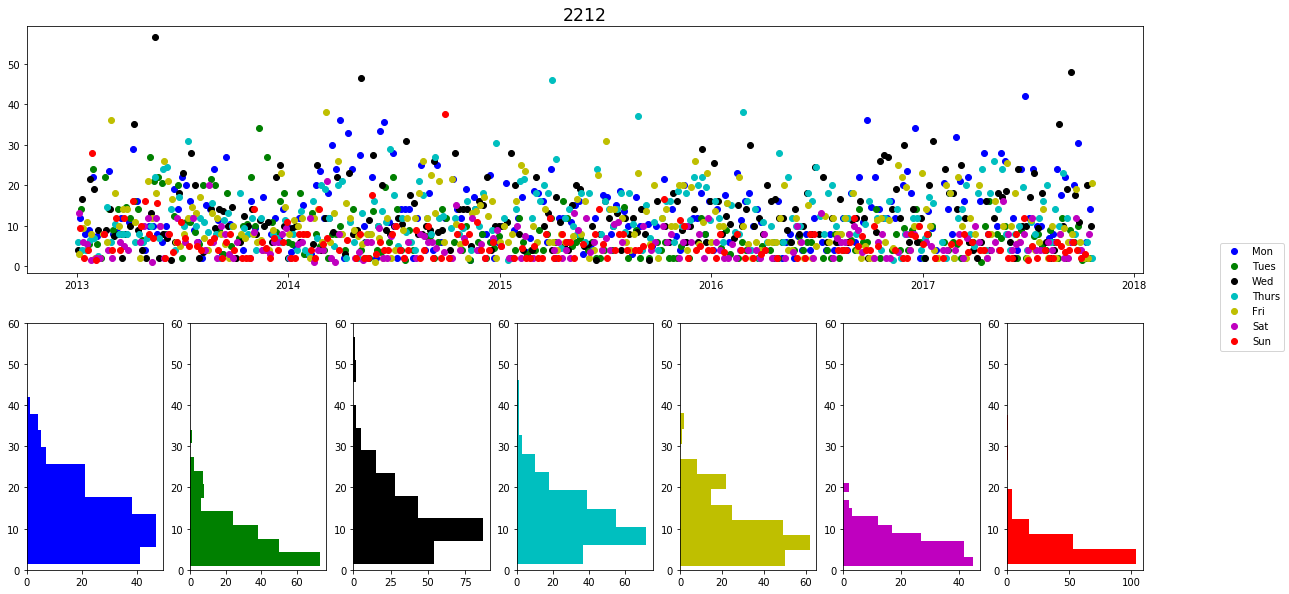

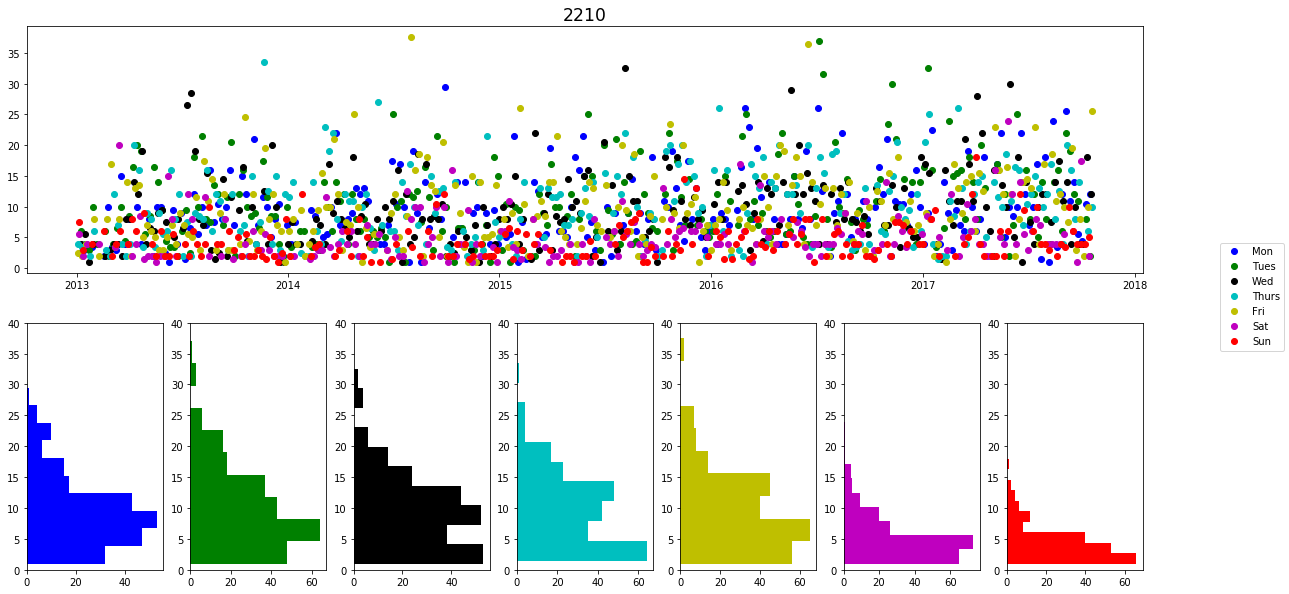

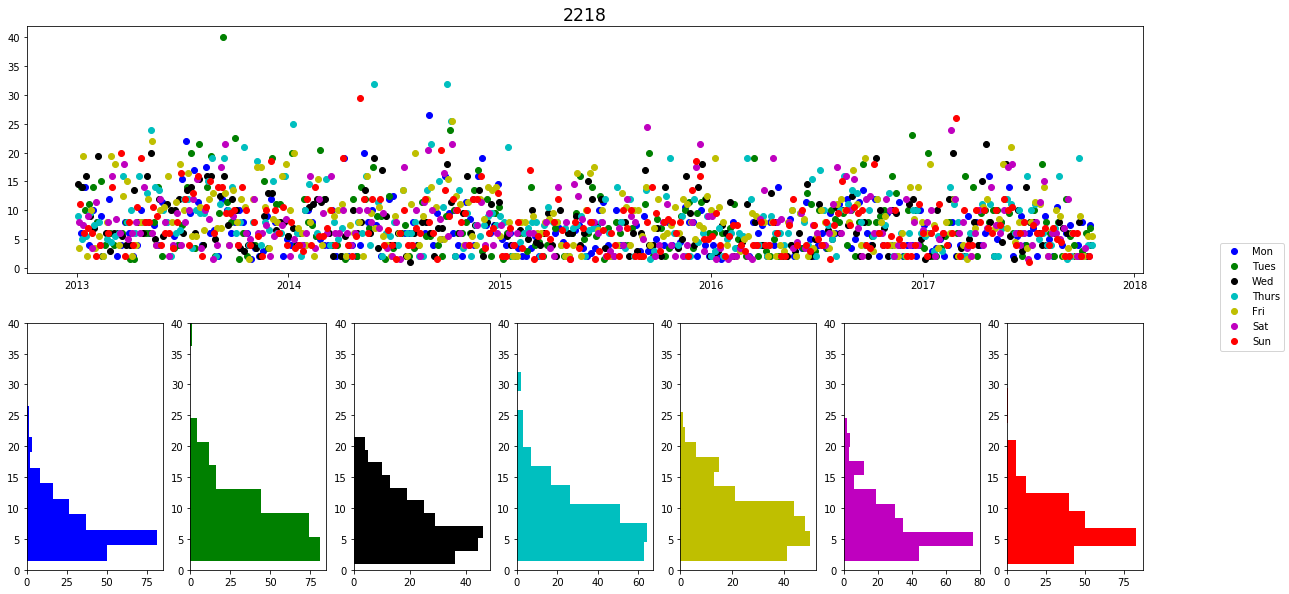

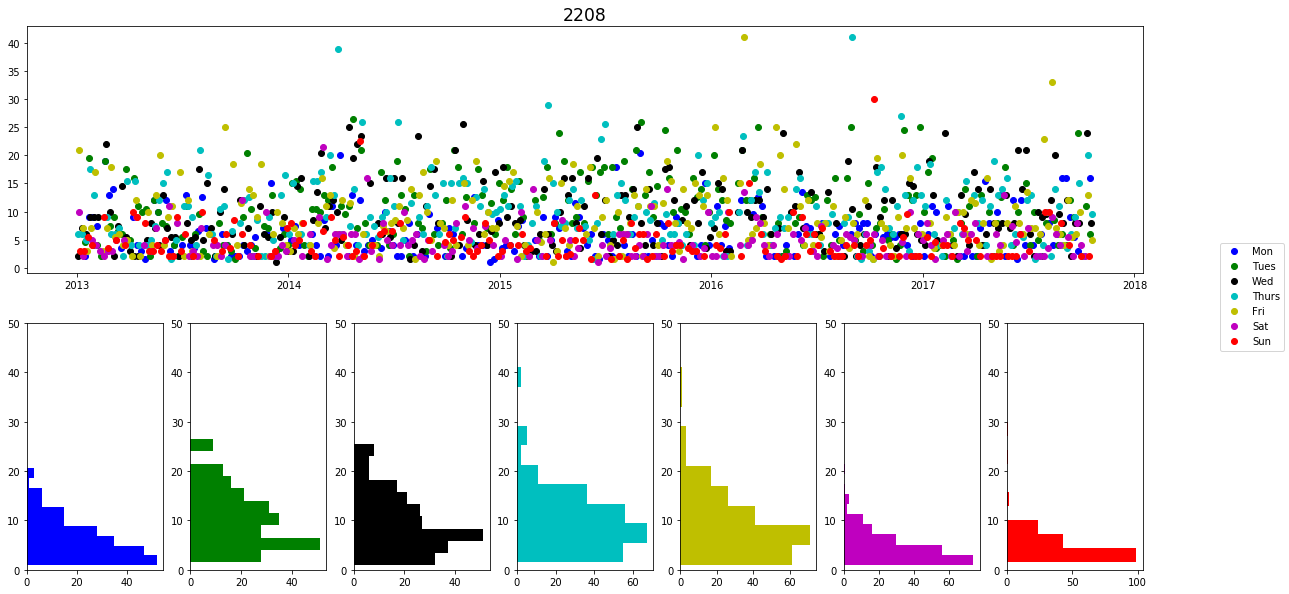

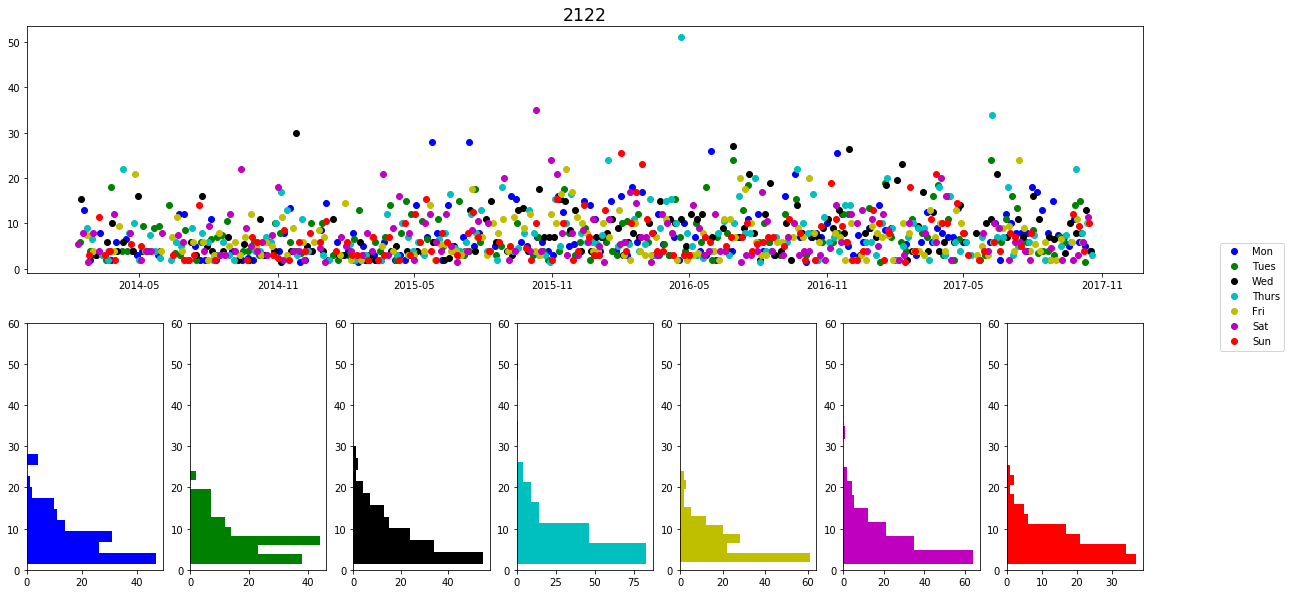

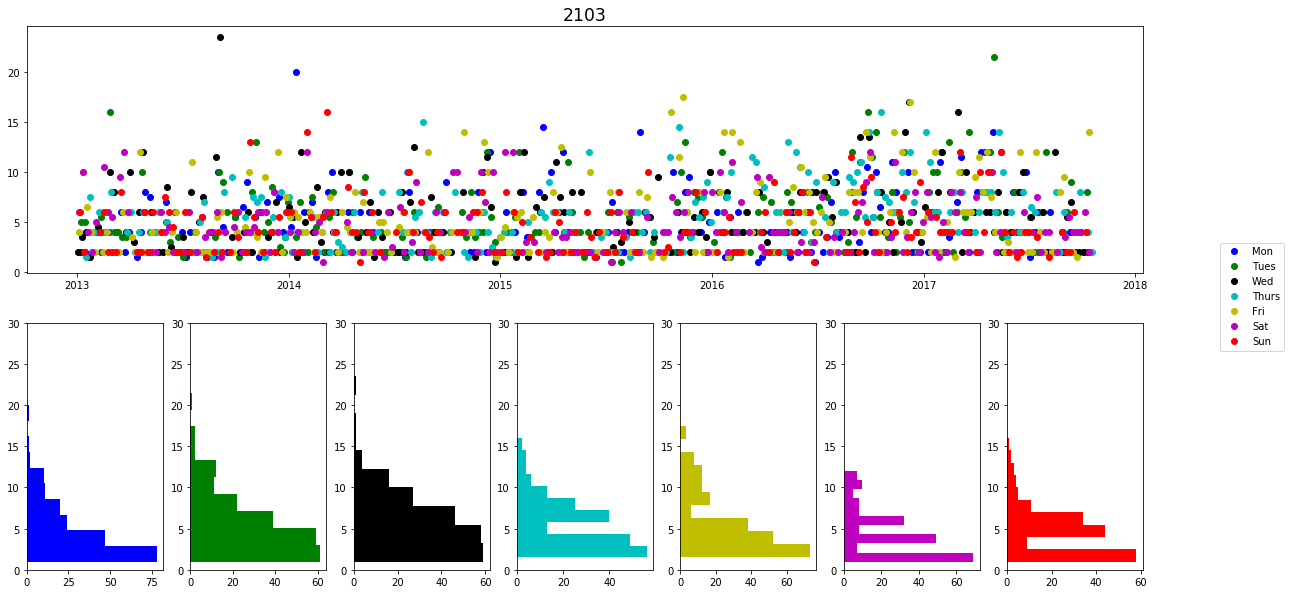

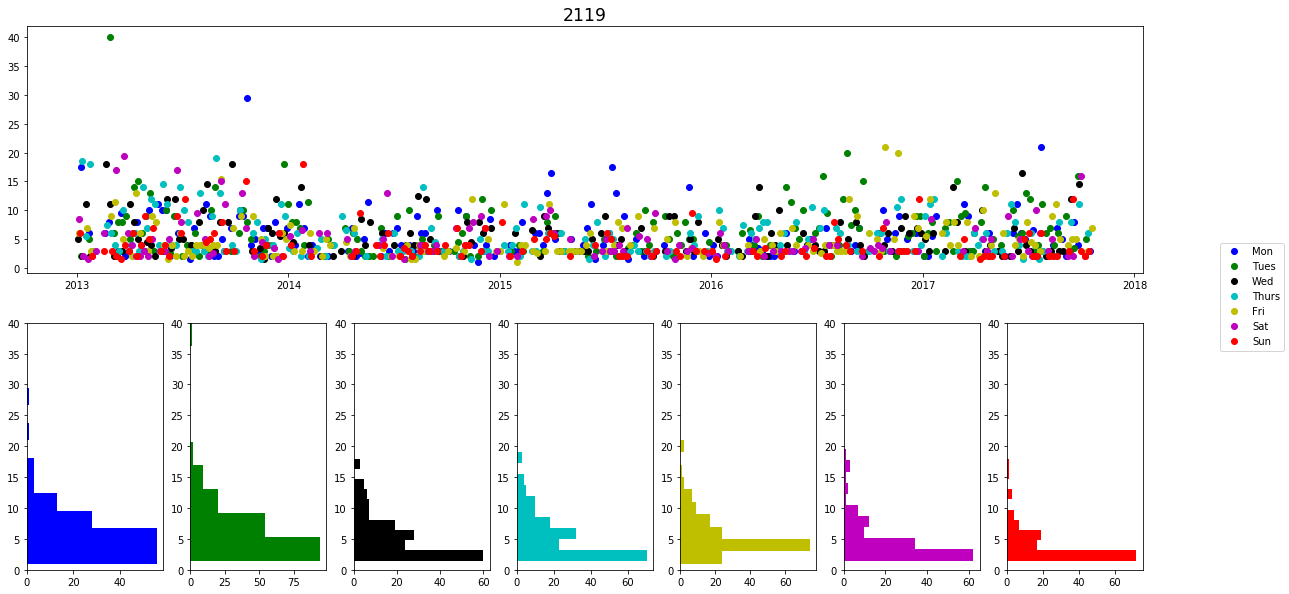

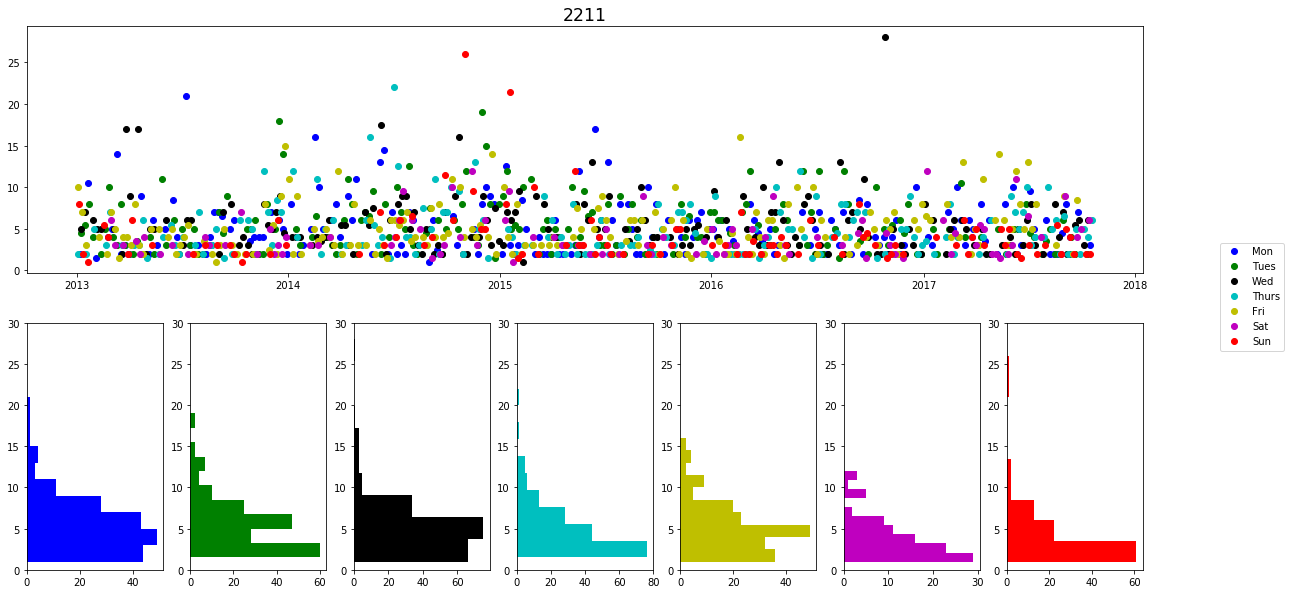

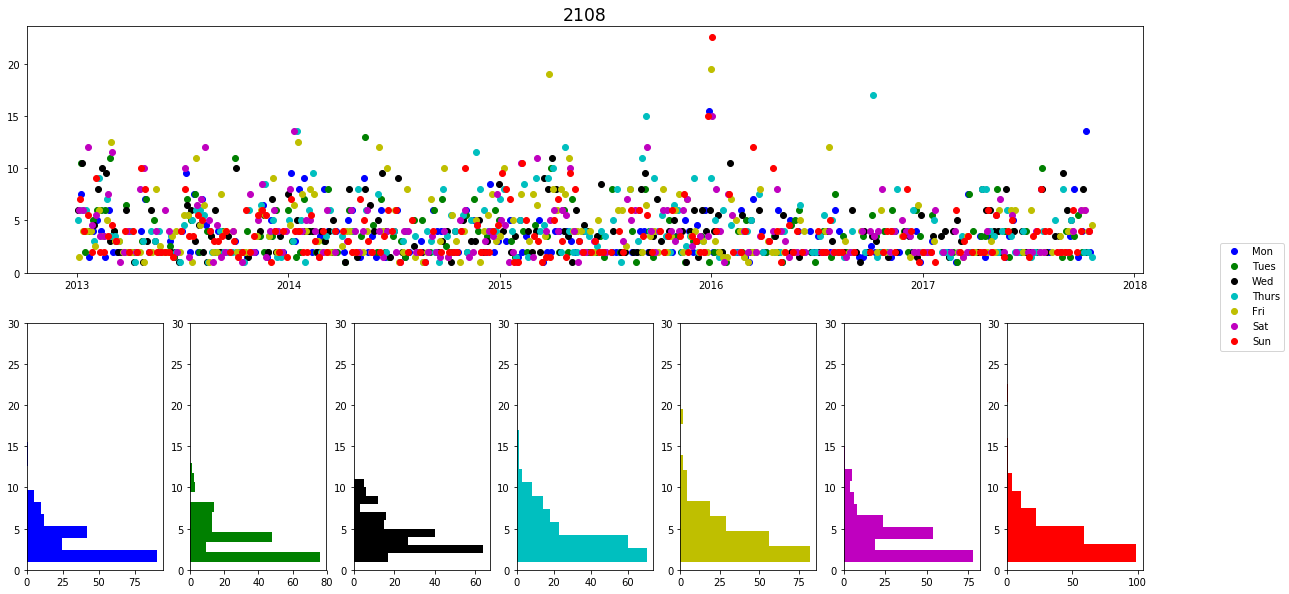

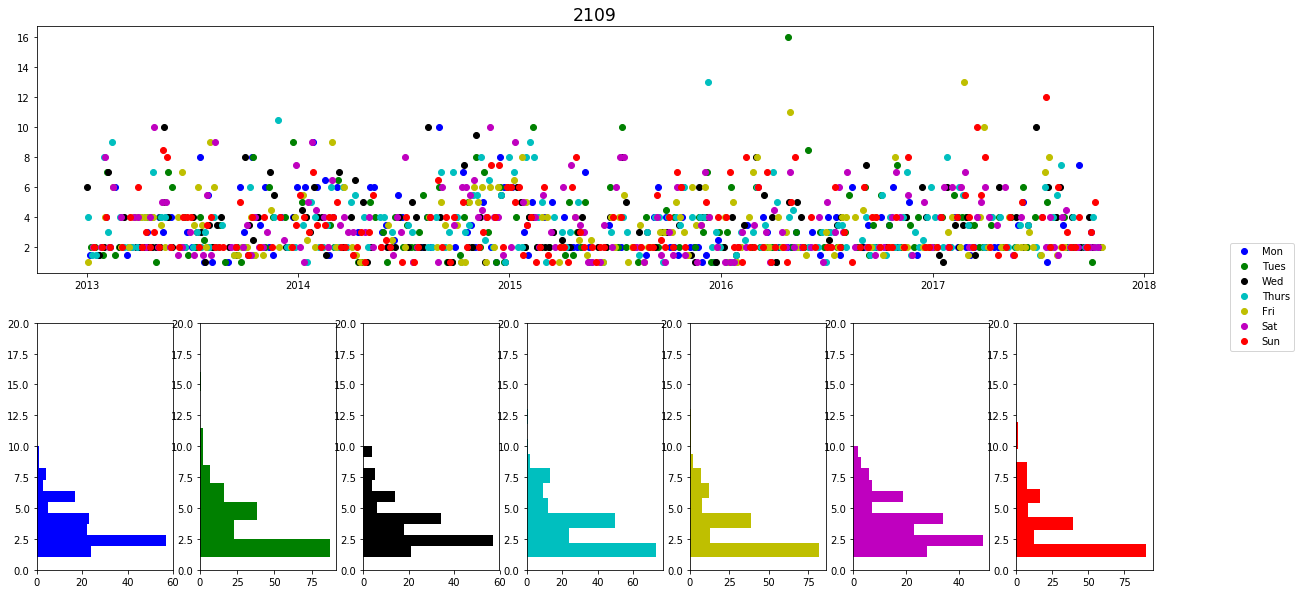

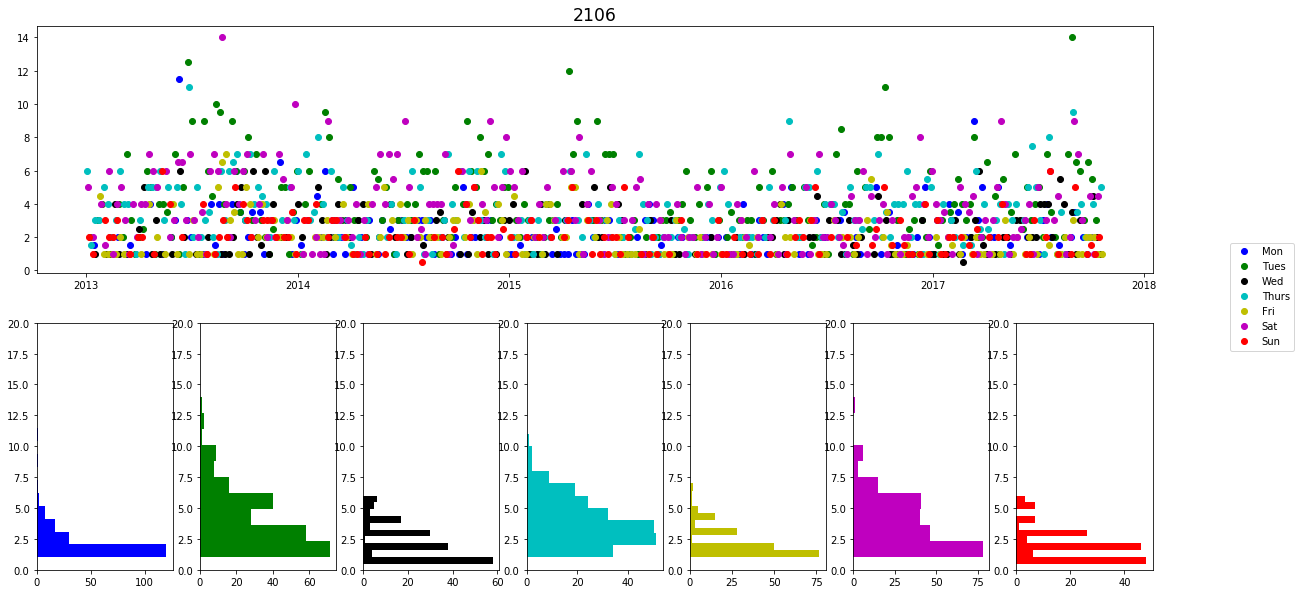

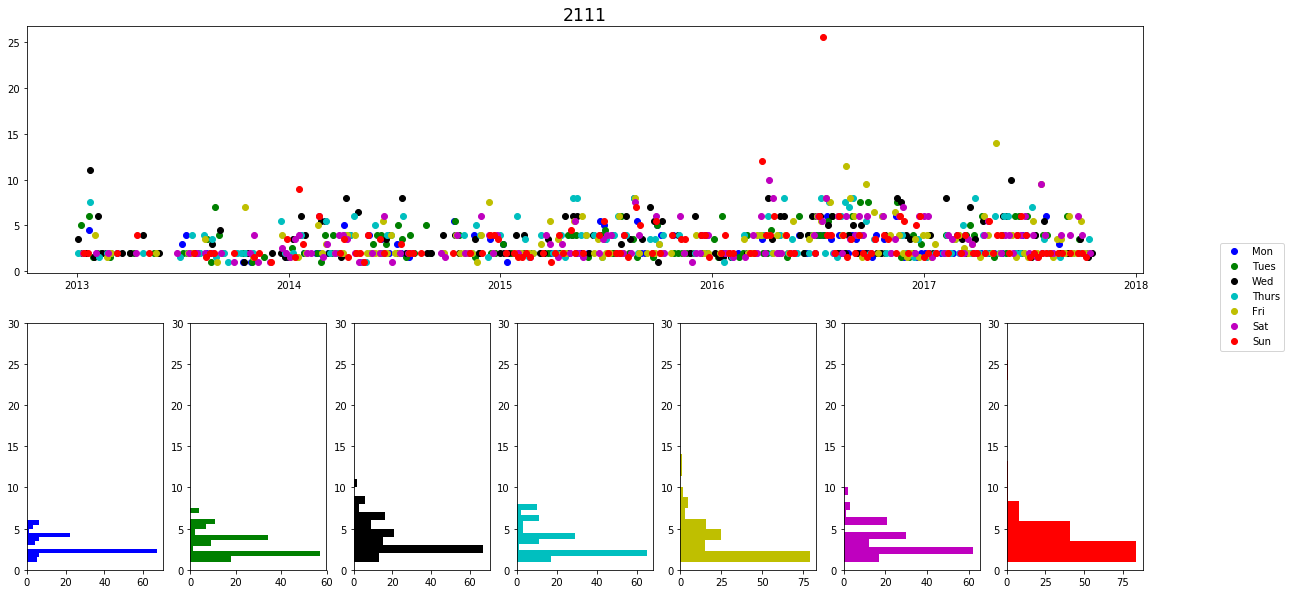

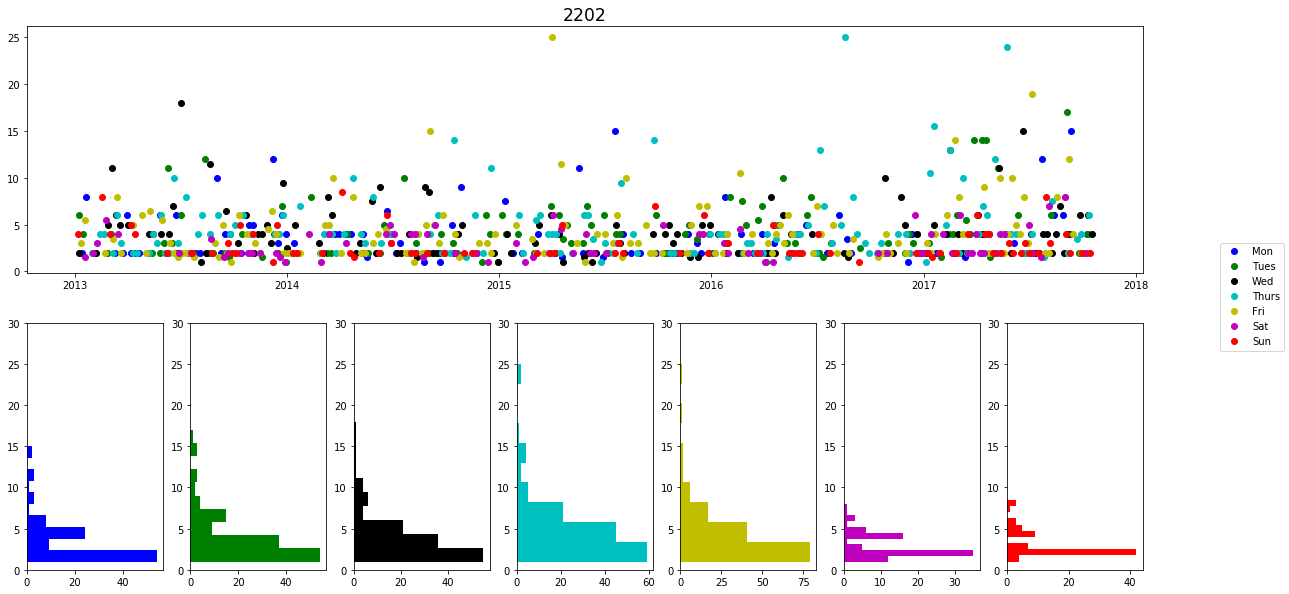

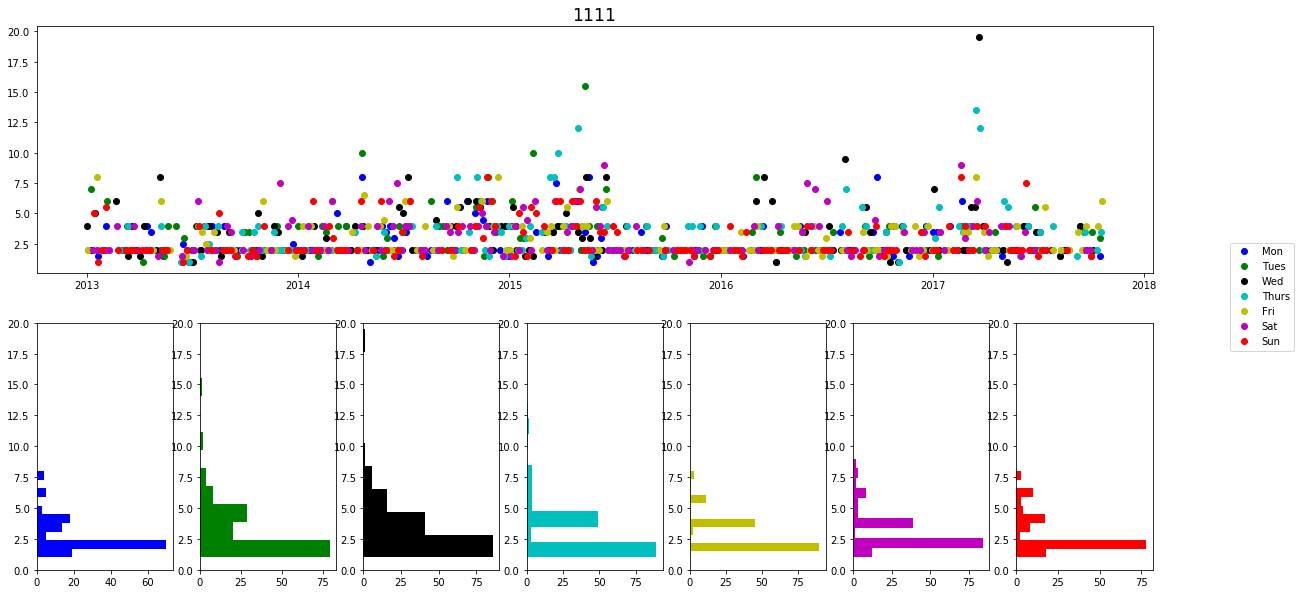

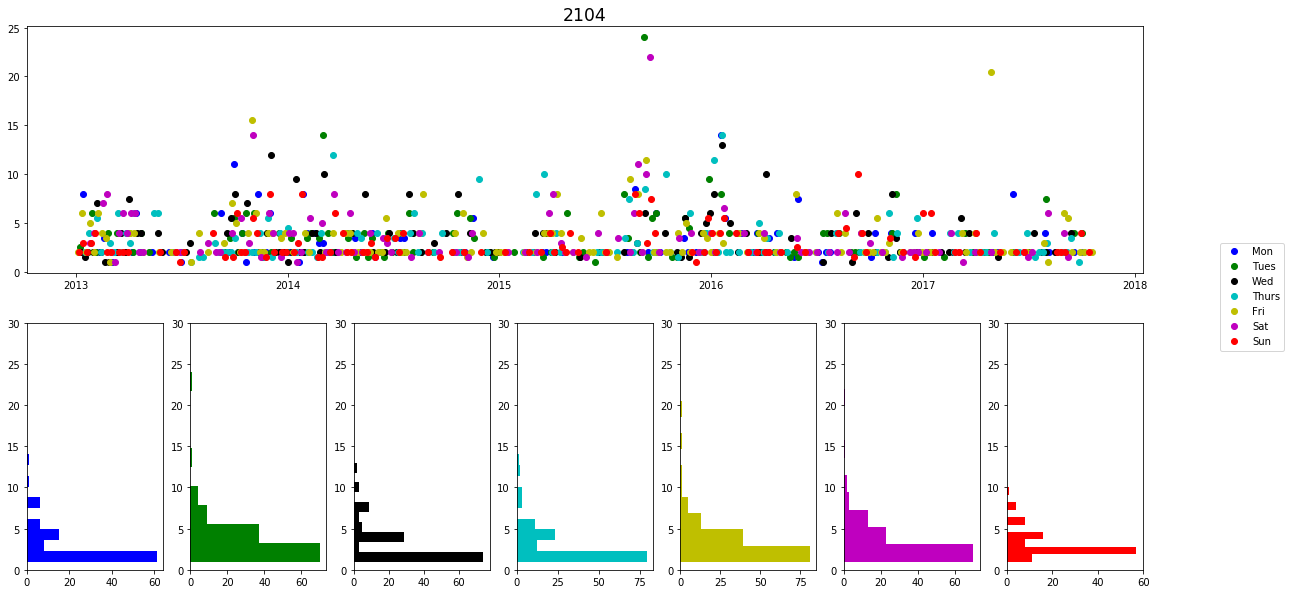

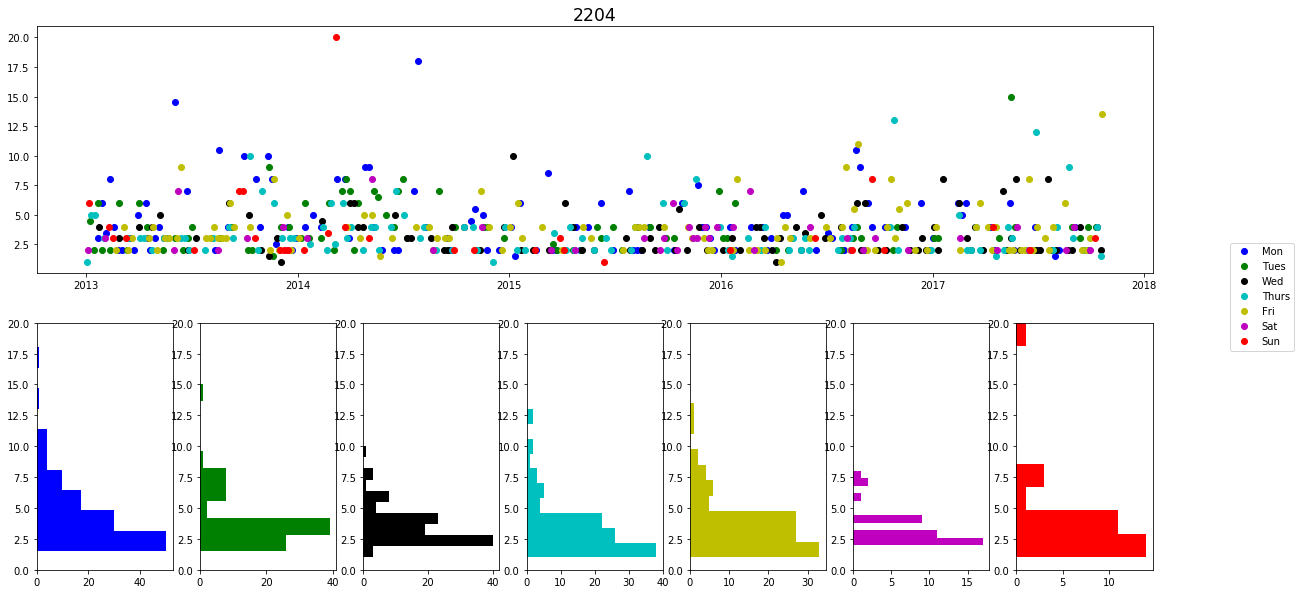

In [9]:
for dc in top_depts[:]:
    dept_df = joined[joined.dept_code == dc]
    plot_seasonality(dept_df, ds_col='trans_dt', y_col='TOTAL', figsize=(20, 10), title=dc, save=True, path=PATH)

In [1]:
!ls ./data

1111.jpg                               2209.jpg
2102.jpg                               2210.jpg
2103.jpg                               2211.jpg
2104.jpg                               2212.jpg
2106.jpg                               2218.jpg
2108.jpg                               4103.jpg
2109.jpg                               DICT_DEPT.txt
2111.jpg                               dataprep_dept_20110101_to_20171020.csv
2119.jpg                               dept_stats.csv
2122.jpg                               dept_stats_viz.csv
2201.jpg                               hol.csv
2202.jpg                               joined.csv
2204.jpg                               joined_hosp.csv
2208.jpg


In [119]:
dept_code = '220104'
dept_df = joined[joined.dept_code == dept_code]

In [120]:
len(dept_df)

1468

## Prophet

In [55]:
# !ls ./data

In [50]:
from fbprophet.diagnostics import cross_validation
from fbprophet import Prophet

In [69]:
## process holidays
hol = pd.read_csv(f'{PATH}/hol.csv')
hol3 = hol[hol.type == 3]
hol3_df = pd.DataFrame({
    'holiday': 'hol3',
    'ds': pd.to_datetime(hol3.ds),
    'lower_window': -1,
    'upper_window': 1
})

hol7 = hol[hol.type == 7]
hol7_df = pd.DataFrame({
    'holiday': 'hol7',
    'ds': pd.to_datetime(hol7.ds),
    'lower_window': -3,
    'upper_window': 3
})
holidays = pd.concat((hol3_df, hol7_df))
holidays.head()

,ds,holiday,lower_window,upper_window
0,2013-01-01,hol3,-1,1
1,2013-01-02,hol3,-1,1
2,2013-01-03,hol3,-1,1
10,2013-04-04,hol3,-1,1
11,2013-04-05,hol3,-1,1


In [140]:
def addPPFeatures(df, y_col='y', ds_col='ds'):
    pp_df = df.copy()
    pp_df['y'] = np.log1p(pp_df[y_col])
    pp_df['ds'] = pp_df[ds_col]
    m = Prophet(holidays=holidays,
            yearly_seasonality=True,
            daily_seasonality=False,
            weekly_seasonality=True
            )
    m.fit(pp_df)
    forecast = m.predict(pp_df)
    pp_df[ds_col] = pd.to_datetime(pp_df[ds_col])
    pp_df = pp_df.drop(columns=['y', 'ds'])
    forecast['ds'] =  pd.to_datetime(forecast.ds)
    for col in forecast.columns:
        forecast = forecast.rename({
            col: f'{y_col}_{col}'
        }, axis='columns')
    joined = pd.merge(pp_df, forecast, how='left', left_on=ds_col, right_on=f'{y_col}_ds')
    return joined

### Hospital All

In [64]:
def rmsle(y_pred, targ):
    log_vars = np.log(targ + 1) - np.log(y_pred + 1)
    return np.sqrt(np.square(log_vars).mean())

def splitTrnValid(data_orig, valid_len):
    data = data_orig.copy()
#     trn_len = int(np.floor(len(data) * ratio))
#     valid_len = len(data) - trn_len
    trn_len = len(data) - valid_len
    trn_data = data[:trn_len]
    valid_data = data[trn_len:]
    return trn_data, valid_data, trn_len, valid_len

#%%
def getSumForPeriod(data, cols, period):
    for col in cols:
        data["prev_{}_{}_sum".format(period, col)] = data[col].rolling(
            period).sum().shift(-6)
    return data

In [113]:
hosp_data = pd.read_csv(f'{PATH}joined_hosp_ner.csv')
hosp_data.head()

,trans_dt,A,B,O,AB,code_len,dow,day,month,year,week,ds,hol_dur,hol_lower,hol_upper,TOTAL
0,2013-01-02,20.0,24.5,28.0,11.0,150,2,2,1,2013,1,2013-01-02,3.0,-1.0,1.0,83.5
1,2013-01-03,22.5,22.0,23.0,11.0,168,3,3,1,2013,1,2013-01-03,3.0,-1.0,1.0,78.5
2,2013-01-04,21.5,33.5,46.0,12.0,186,4,4,1,2013,1,NaN,NaN,NaN,NaN,113.0
3,2013-01-05,28.0,25.0,43.0,21.5,166,5,5,1,2013,1,NaN,NaN,NaN,NaN,117.5
4,2013-01-06,22.0,42.0,36.5,17.5,186,6,6,1,2013,1,NaN,NaN,NaN,NaN,118.0


In [138]:
hosp_df = hosp_data.rename({
    'ds': 'hds',
#     'trans_dt': 'ds',
#     'TOTAL': 'y'
}, axis='columns')
# hosp_df['y'] = np.log1p(hosp_df.y)

In [145]:
for t in ['A', 'B', 'AB', 'O', 'TOTAL']:
    hosp_df = addPPFeatures(hosp_df, y_col=t, ds_col='trans_dt')

In [147]:
hosp_df.drop(columns='code_len', inplace=True)

In [148]:
hosp_df.to_csv(f'{PATH}joined_hosp_pp.csv', index=False)

0.20753031770014663

0.36759641277294075

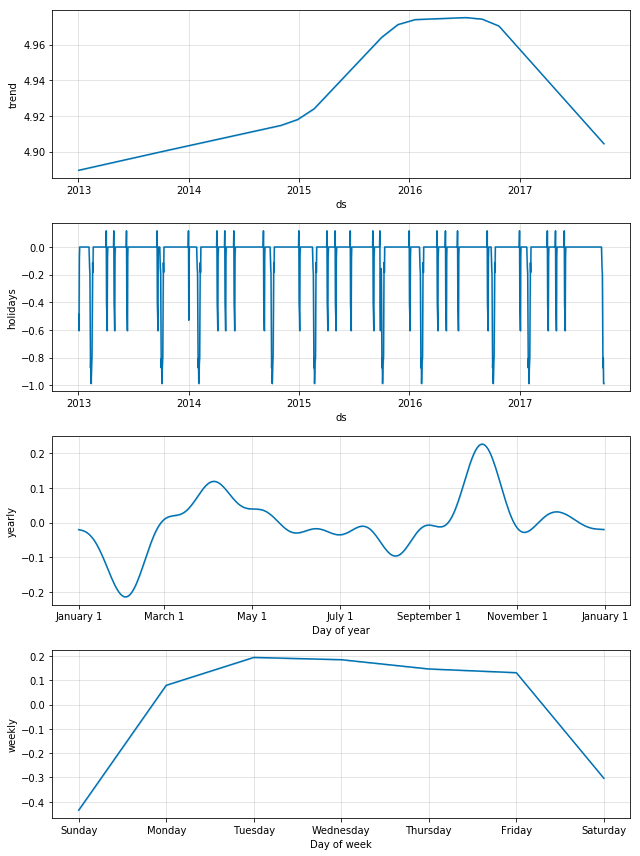

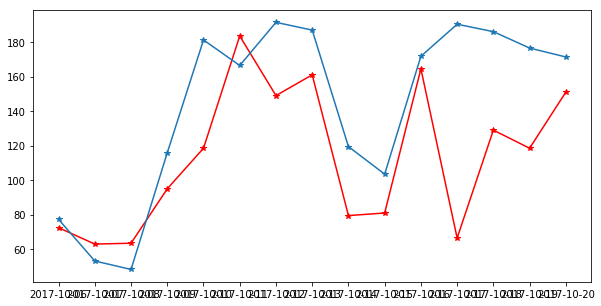

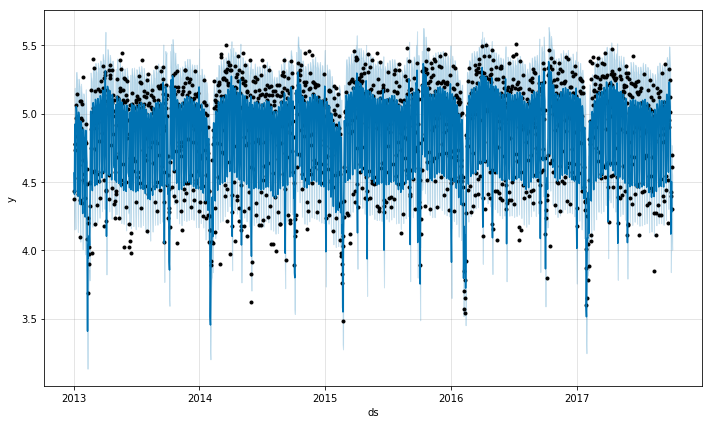

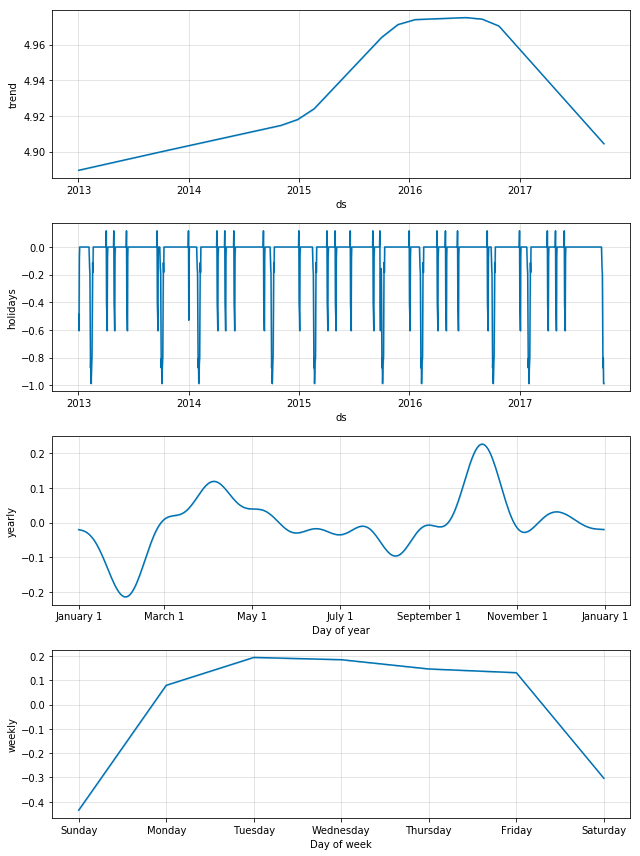

In [116]:
trn_df, valid_df, trn_len, valid_len = splitTrnValid(hosp_df, 15)
m = Prophet(holidays=holidays,
            yearly_seasonality=True,
            daily_seasonality=False,
            weekly_seasonality=True
            )
m.fit(trn_df)
forecast = m.predict(valid_df)
simulate = m.predict(trn_df)
losst = rmsle(np.exp(simulate.yhat.values) - 1, np.exp(trn_df.y.values) - 1)
lossv = rmsle(np.exp(forecast.yhat.values) - 1, np.exp(valid_df.y.values) - 1)

display(losst, lossv)
plt.figure(figsize=(10, 5))
plt.plot(valid_df.ds, np.exp(valid_df.y.values) - 1, 'r-*')
plt.plot(valid_df.ds, np.exp(forecast.yhat.values) - 1, '-*')

m.plot(simulate)
m.plot_components(simulate)

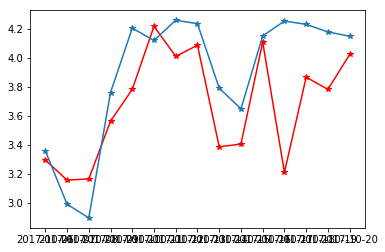

In [117]:
plt.plot(valid_df.ds, valid_df.y.values - 1, 'r-*')
plt.plot(valid_df.ds, forecast.yhat.values - 1, '-*')

### Departments

In [121]:
!ls -alh ./data

total 35568
drwxr-xr-x  37 yangyang  staff   1.2K Feb  8 10:17 .
drwxr-xr-x   8 yangyang  staff   272B Feb  8 10:23 ..
-rw-r--r--@  1 yangyang  staff   6.0K Feb  7 09:23 .DS_Store
-rw-r--r--@  1 yangyang  staff   147K Feb  7 17:42 1111.jpg
-rw-r--r--@  1 yangyang  staff   202K Feb  7 17:41 2102.jpg
-rw-r--r--@  1 yangyang  staff   181K Feb  7 17:41 2103.jpg
-rw-r--r--@  1 yangyang  staff   135K Feb  7 17:42 2104.jpg
-rw-r--r--@  1 yangyang  staff   194K Feb  7 17:42 2106.jpg
-rw-r--r--@  1 yangyang  staff   168K Feb  7 17:42 2108.jpg
-rw-r--r--@  1 yangyang  staff   176K Feb  7 17:42 2109.jpg
-rw-r--r--@  1 yangyang  staff   132K Feb  7 17:42 2111.jpg
-rw-r--r--@  1 yangyang  staff   155K Feb  7 17:41 2119.jpg
-rw-r--r--@  1 yangyang  staff   161K Feb  7 17:41 2122.jpg
-rw-r--r--@  1 yangyang  staff   245K Feb  7 17:41 2201.jpg
-rw-r--r--@  1 yangyang  staff   145K Feb  7 17:42 2202.jpg
-rw-r--r--@  1 yangyang  staff   148K Feb  7 17:42 2204.jpg
-rw-r--r--@  1 yangyang  staff   190K Fe

In [120]:
dept_data = pd.read_csv(f'{PATH}joined.csv')
dept_data.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,A,AB,B,O,dept_code,dept_name,pdept_code,trans_dt,dow,day,month,year,week,hol_dur,hol_lower,hol_upper,TOTAL
0,2.0,0.0,2.0,0.0,111111,生物治疗病区,1111,2013-01-02,2,2,1,2013,1,3.0,-1.0,1.0,4.0
1,2.0,0.0,0.0,4.0,210201,血液病科一病区,2102,2013-01-02,2,2,1,2013,1,3.0,-1.0,1.0,6.0
2,4.0,0.0,2.0,2.0,210204,造血干细胞移植病房,2102,2013-01-02,2,2,1,2013,1,3.0,-1.0,1.0,8.0
3,0.0,1.5,0.0,0.0,210205,血液病科康复病区,2102,2013-01-02,2,2,1,2013,1,3.0,-1.0,1.0,1.5
4,0.0,0.0,2.0,0.0,210304,消化内科四病区,2103,2013-01-02,2,2,1,2013,1,3.0,-1.0,1.0,2.0


## DL

In [214]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

In [215]:
# joined = pd.read_csv(f'{PATH}joined_hosp_pp.csv')
joined = pd.read_csv(f'{PATH}joined_hosp_dept.csv', dtype={'dept_code': 'str', 'pdept_code': 'str'})

In [180]:
joined.columns.tolist()

['A',
 'AB',
 'B',
 'O',
 'TOTAL',
 'day',
 'dept_code',
 'dept_name',
 'dow',
 'hol_dur',
 'hol_lower',
 'hol_upper',
 'month',
 'pdept_code',
 'trans_dt',
 'week',
 'year']

In [216]:
joined['hol_dur'] = joined.hol_dur.fillna(0)
joined['hol_lower'] = joined.hol_dur.fillna(0)
joined['hol_upper'] = joined.hol_dur.fillna(0)

In [201]:
joined = joined[joined.dept_code == '0']

In [217]:
cat_vars = ['dow', 'day', 'month', 'year', 'week', 'dept_code', 'pdept_code']

contin_vars = [ 
      'hol_dur',
     'hol_lower',
     'hol_upper',
]
all_vars = cat_vars + contin_vars
dep = 'TOTAL'
joined = joined[all_vars+[dep, 'trans_dt']]
joined['trans_dt'] = pd.to_datetime(joined.trans_dt)

for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

# for v in contin_vars:
#     joined[v] = joined[v].astype('float32')

joined = joined.set_index("trans_dt")
df, y, nas, mapper = proc_df(joined, 'TOTAL', do_scale=True)
yl = np.log1p(y)
val_idx = np.flatnonzero(df.index>=datetime.datetime(2017,8,1))

In [218]:
len(val_idx), len(df)

(4433, 96286)

In [219]:
def inv_y(a): return np.exp(a) - 1

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = np.log1p(targ) - np.log1p(inv_y(y_pred))
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [186]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=32)

In [187]:
cat_sz = [(c, len(joined[c].cat.categories)+1) for c in cat_vars]

In [188]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [168]:
emb_szs

[(8, 4), (32, 16), (13, 7), (6, 3), (54, 27), (2, 1), (2, 1)]

In [192]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [128, 64], [0.01, 0.01], y_range=y_range, use_bn=True)
lr = 1e-3

In [193]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 66%|██████▌   | 1896/2871 [00:13<00:07, 136.24it/s, loss=0.908]

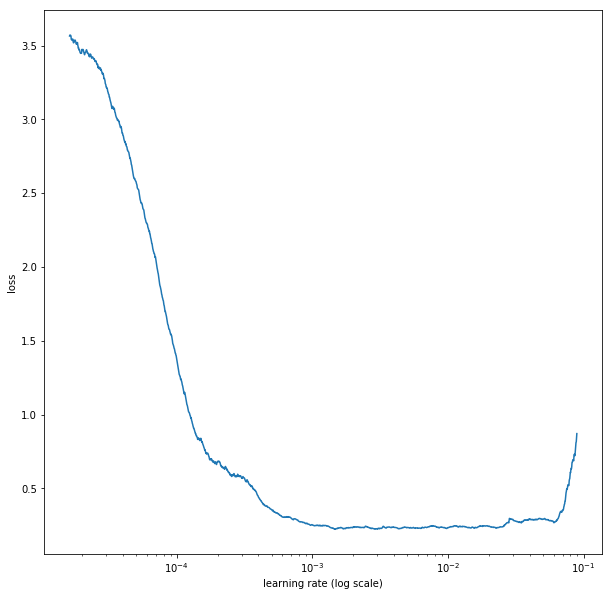

 66%|██████▌   | 1896/2871 [00:30<00:15, 63.17it/s, loss=0.908] 

In [194]:
rcParams['figure.figsize'] = 10, 10
m.sched.plot(100)

In [189]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [128, 64], [0.01, 0.01], y_range=y_range, use_bn=True)
lr = 1e-4

In [196]:
%time m.fit(lr, 3, metrics=[exp_rmspe])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))


  2%|▏         | 60/2871 [00:02<02:05, 22.42it/s, loss=1.01]
                                                               A
  3%|▎         | 87/2871 [00:02<01:33, 29.80it/s, loss=0.708]

Exception in thread Thread-77:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Exception in thread Thread-78:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.p

[ 0.       0.19282  0.20902  0.45399]                           
[ 1.       0.19057  0.2084   0.45287]                           
[ 2.       0.18319  0.1954   0.43817]                           

CPU times: user 53.3 s, sys: 10.6 s, total: 1min 3s
Wall time: 59.1 s


In [191]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.19198  0.20241  0.44733]                           
[ 1.       0.19579  0.20437  0.44931]                           
[ 2.       0.18695  0.19873  0.44297]                           
[ 3.       0.19151  0.19784  0.44183]                           
[ 4.       0.18331  0.19276  0.43595]                           
[ 5.       0.19017  0.19373  0.43698]                           
[ 6.       0.18071  0.19401  0.43728]                           



In [76]:
val_hosp_idx =  np.flatnonzero((df.index>=datetime.datetime(2017,8,1)) & (df.dept_code == 1))

In [80]:
subdf = df[(df.index>=datetime.datetime(2017,8,1))]
sub_idx = np.flatnonzero((subdf.dept_code == 1))

In [81]:
len(sub_idx)

81

In [172]:
pred = m.predict(False)

In [147]:
len(pred)

81

#### Train ONLY hospital data

#### Train the whole set

In [91]:
exp_rmspe(pred[sub_idx], np.log1p(y[val_hosp_idx]))

0.42681493690139893

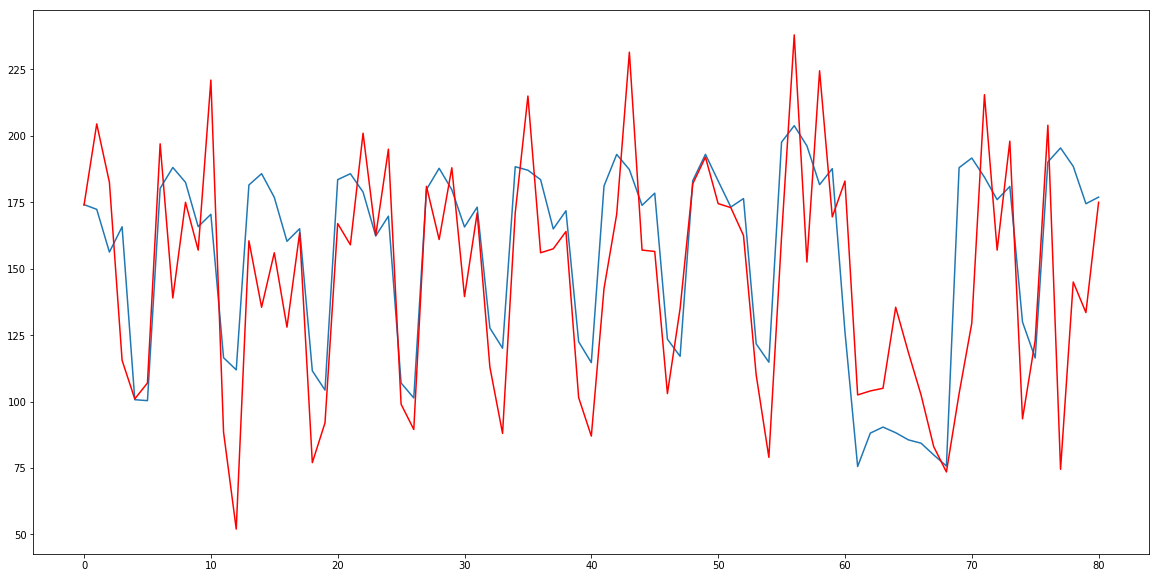

In [92]:
plt.figure(figsize=(20, 10))
plt.plot(np.exp(pred[sub_idx]) - 1)
plt.plot(y[val_hosp_idx], 'r')

### Random Forest

In [220]:
from sklearn.ensemble import RandomForestRegressor

In [221]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

In [222]:
m = RandomForestRegressor(n_estimators=10, max_features=0.99,  max_depth=15, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [223]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)

(0.80743502944103596,
 0.70331198964519859,
 0.68489273192719735,
 0.4435887554487633)

In [224]:
fi = rf_feat_importance(m, df); fi[:10]

,cols,imp
5,dept_code,0.783552
6,pdept_code,0.077088
0,dow,0.047666
1,day,0.028106
4,week,0.028043
3,year,0.017551
2,month,0.008101
9,hol_upper,0.003959
8,hol_lower,0.003029
7,hol_dur,0.002906


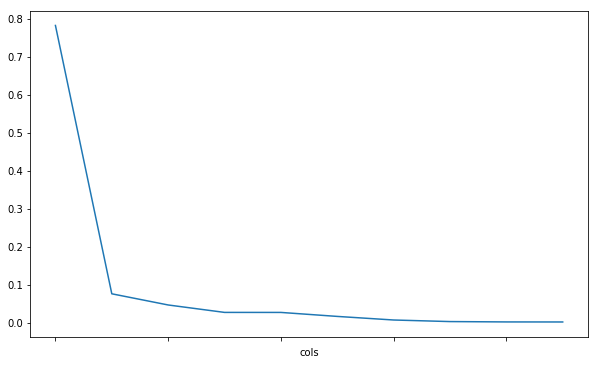

In [225]:
fi.plot('cols', 'imp', figsize=(10, 6), legend=False)

In [173]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=30, oob_score=True, max_features='sqrt')
m.fit(trn, y_trn);
preds = np.stackpreds = np.mean(preds, axis=0)([t.predict(val) for t in m.estimators_])

m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)

(0.96287611077976676,
 0.59730407110912853,
 0.73562280837986149,
 0.22267788849518905)

In [210]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=30, oob_score=True, max_features='log2')
m.fit(trn, y_trn);
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)

(0.96031585201090564,
 0.59258436991605357,
 0.72773285024328205,
 0.22397900866538348)

In [211]:
preds = np.stack([t.predict(val) for t in m.estimators_])
preds2 = np.mean(preds, axis=0)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds2, y_val)

(0.96031585201090564,
 0.59258436991605379,
 0.72773285024328205,
 0.22397900866538353)

In [197]:
preds.shape

(81,)

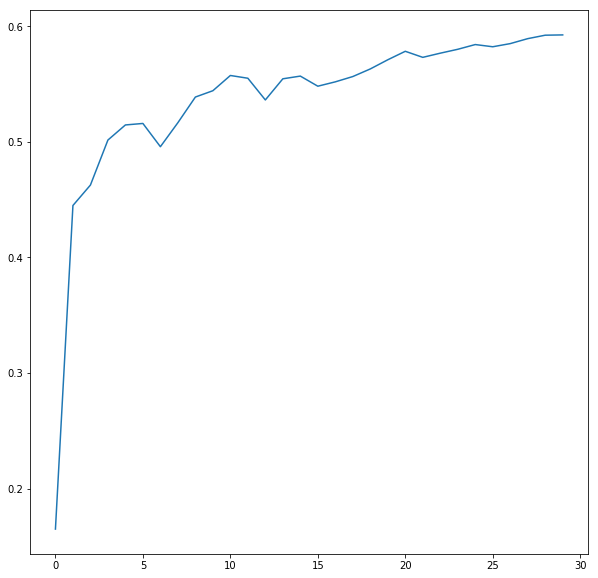

In [212]:
plt.plot([metrics.r2_score(y_val, np.mean(preds[:i+1], axis=0)) for i in range(30)]);